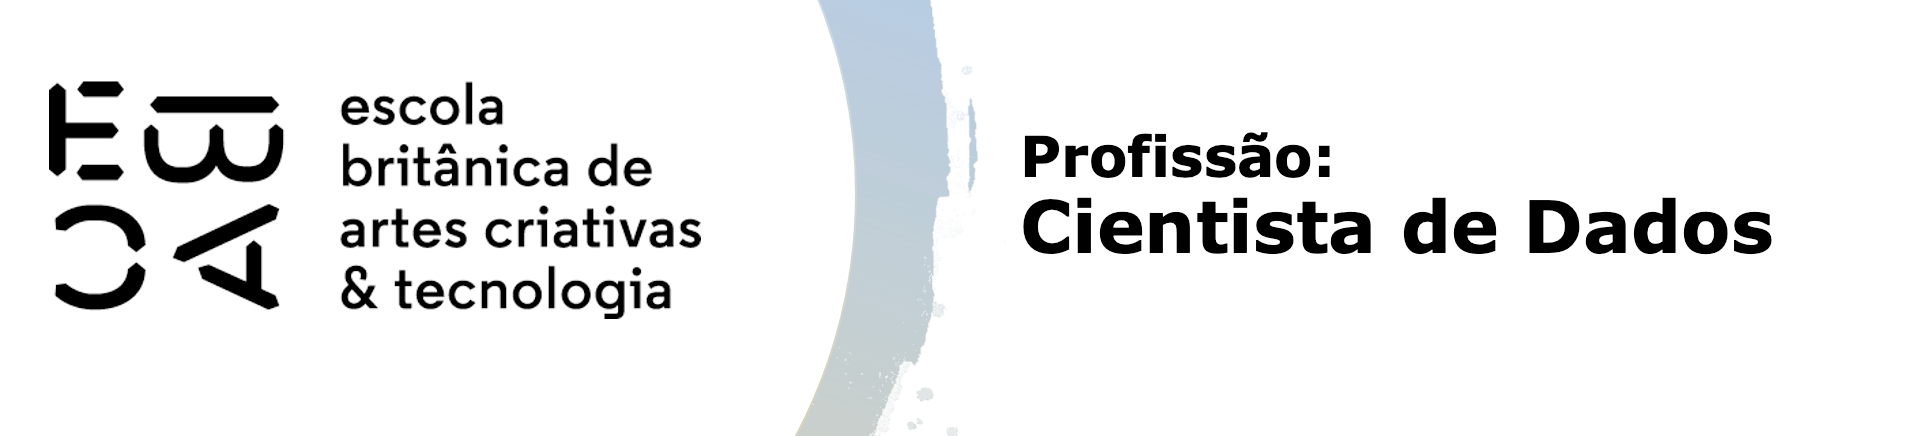

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [170]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm  
import plotly.express as px

from sklearn.metrics import accuracy_score
from pycaret.classification import *
#from pycaret.classification import check_metric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from datetime import datetime, timedelta

In [2]:
# carregando dados

df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Garantir que a coluna está no formato datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Sortear amostra de 200.000 registros (com reposição=False para não repetir linhas)
df_amostra = df.sample(n=10_000, random_state=42)

# Última data da amostra
ultima_data = df_amostra['data_ref'].max()

# Primeiro dia do mês da última data
primeiro_dia_mes_atual = ultima_data.replace(day=1)

# Subtrair 3 meses para definir limite do OOT
data_limite = (primeiro_dia_mes_atual - pd.DateOffset(months=3))

# Separar base de desenvolvimento (antes do OOT)
df_desenvolvimento = df_amostra[df_amostra['data_ref'] < data_limite].drop(columns=['index'], errors='ignore')

# Separar base de validação (OOT) - últimos 3 meses
df_oot = df_amostra[df_amostra['data_ref'] >= data_limite].drop(columns=['index'], errors='ignore')

# Verificar as formas
print(f"df Original: {df.shape}")
print(f"Amostra de 200.000: {df_amostra.shape}")
print(f"Desenvolvimento: {df_desenvolvimento.shape}")
print(f"OOT: {df_oot.shape}")


df Original: (750000, 15)
Amostra de 200.000: (10000, 15)
Desenvolvimento: (7292, 14)
OOT: (2708, 14)


In [4]:
# quantidade de "maus"

df_oot.mau.value_counts()

mau
False    2333
True      375
Name: count, dtype: int64

In [5]:
# porcentagem

df_oot.mau.value_counts(normalize=True)

mau
False    0.861521
True     0.138479
Name: proportion, dtype: float64

In [6]:
# metadados

metadados = pd.DataFrame(df_desenvolvimento.dtypes, columns=['dtype'])
metadados['nmissing'] = df_desenvolvimento.isna().sum()
metadados['valores_unicos'] = df_desenvolvimento.nunique()

metadados

dtype  nmissing  valores_unicos
data_ref               datetime64[ns]         0              11
sexo                           object         0               2
posse_de_veiculo               object         0               2
posse_de_imovel                object         0               2
qtd_filhos                      int64         0               5
tipo_renda                     object         0               5
educacao                       object         0               5
estado_civil                   object         0               5
tipo_residencia                object         0               6
idade                           int64         0              47
tempo_emprego                 float64      1209            2176
qt_pessoas_residencia         float64         0               6
renda                         float64         0            7043
mau                              bool         0               2

In [7]:
# Transformar a variável resposta em inteiro

df_desenvolvimento['mau'] = df_desenvolvimento.mau.astype('int64')

In [8]:
# visualizar

df_desenvolvimento.head()

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
404846 2015-09-01    F                N               S           0   
370876 2015-08-01    M                S               N           1   
239330 2015-05-01    F                S               N           0   
491326 2015-10-01    F                N               S           0   
271448 2015-06-01    F                N               S           0   

              tipo_renda           educacao estado_civil tipo_residencia  \
404846       Pensionista              Médio       Casado            Casa   
370876        Empresário  Superior completo       Casado   Governamental   
239330  Servidor público              Médio        União            Casa   
491326       Pensionista              Médio       Casado   Governamental   
271448       Assalariado              Médio       Casado            Casa   

        idade  tempo_emprego  qt_pessoas_residencia      renda  mau  
404846     62            NaN                    2.0    5466.64    0  
370876     42       2.432877                    3.0   12398.49    0  
239330     45      19.534247                    2.0  101062.66    0  
491326     59            NaN                    2.0   10774.15    0  
271448     47       3.046575                    2.0    4083.24    0

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [9]:
# número total de linhas

total_linhas = len(df_desenvolvimento)
print(f"Número total de linhas: {total_linhas}")

Número total de linhas: 7292


In [10]:
# número de linhas por mês

df_desenvolvimento['ano_mes'] = df_desenvolvimento['data_ref'].dt.to_period('M')
contagem_mensal = df_desenvolvimento['ano_mes'].value_counts().sort_index()
print("\nNúmero de linhas por mês:")
print(contagem_mensal)


Número de linhas por mês:
ano_mes
2015-01    651
2015-02    650
2015-03    647
2015-04    727
2015-05    686
2015-06    640
2015-07    680
2015-08    653
2015-09    637
2015-10    665
2015-11    656
Freq: M, Name: count, dtype: int64


In [11]:
# descrição variáveis

df = df_desenvolvimento.copy()  # ou df, conforme sua base

# Separar variáveis qualitativas (objetos e booleanos) e quantitativas (numéricas)
variaveis_categoricas = df.select_dtypes(include=['object', 'category', 'bool']).columns
variaveis_numericas = df.select_dtypes(include=['number']).columns

print("=== ANÁLISE DESCRITIVA: VARIÁVEIS CATEGÓRICAS ===")
for col in variaveis_categoricas:
    print(f"\nColuna: {col}")
    print(df[col].value_counts())
    print("\nFrequência relativa (%):")
    print((df[col].value_counts(normalize=True) * 100).round(2))

print("\n\n=== ANÁLISE DESCRITIVA: VARIÁVEIS NUMÉRICAS ===")
print(df[variaveis_numericas].describe().T.round(2))

=== ANÁLISE DESCRITIVA: VARIÁVEIS CATEGÓRICAS ===

Coluna: sexo
sexo
F    4919
M    2373
Name: count, dtype: int64

Frequência relativa (%):
sexo
F    67.46
M    32.54
Name: proportion, dtype: float64

Coluna: posse_de_veiculo
posse_de_veiculo
N    4426
S    2866
Name: count, dtype: int64

Frequência relativa (%):
posse_de_veiculo
N    60.7
S    39.3
Name: proportion, dtype: float64

Coluna: posse_de_imovel
posse_de_imovel
S    4807
N    2485
Name: count, dtype: int64

Frequência relativa (%):
posse_de_imovel
S    65.92
N    34.08
Name: proportion, dtype: float64

Coluna: tipo_renda
tipo_renda
Assalariado         3747
Empresário          1679
Pensionista         1215
Servidor público     648
Bolsista               3
Name: count, dtype: int64

Frequência relativa (%):
tipo_renda
Assalariado         51.39
Empresário          23.03
Pensionista         16.66
Servidor público     8.89
Bolsista             0.04
Name: proportion, dtype: float64

Coluna: educacao
educacao
Médio                

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


=== Correlação entre variáveis numéricas ===
                       qtd_filhos  idade  tempo_emprego  \
qtd_filhos                   1.00  -0.39          -0.08   
idade                       -0.39   1.00           0.34   
tempo_emprego               -0.08   0.34           1.00   
qt_pessoas_residencia        0.89  -0.35          -0.07   
renda                       -0.05   0.11           0.54   
mau                          0.01  -0.04          -0.11   

                       qt_pessoas_residencia  renda   mau  
qtd_filhos                              0.89  -0.05  0.01  
idade                                  -0.35   0.11 -0.04  
tempo_emprego                          -0.07   0.54 -0.11  
qt_pessoas_residencia                   1.00  -0.05  0.00  
renda                                  -0.05   1.00 -0.07  
mau                                     0.00  -0.07  1.00  


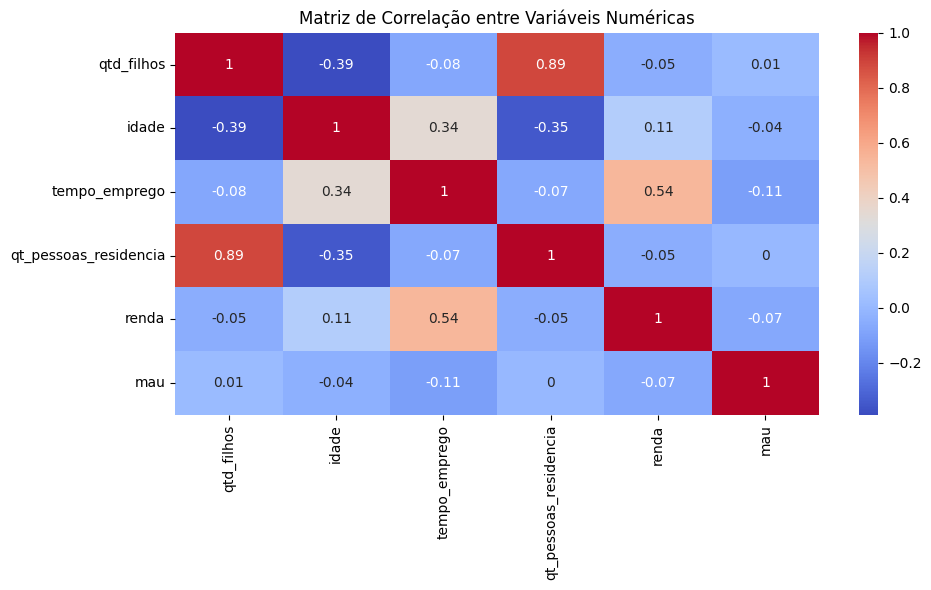


=== Tabelas de Contingência (Qualitativas x Qualitativas) ===

sexo x posse_de_veiculo
posse_de_veiculo     N     S
sexo                        
F                 3589  1330
M                  837  1536

sexo x posse_de_imovel
posse_de_imovel     N     S
sexo                       
F                1573  3346
M                 912  1461

sexo x tipo_renda
tipo_renda  Assalariado  Bolsista  Empresário  Pensionista  Servidor público
sexo                                                                        
F                  2274         3        1123         1046               473
M                  1473         0         556          169               175

sexo x educacao
educacao  Fundamental  Médio  Pós graduação  Superior completo  \
sexo                                                             
F                  50   3329              7               1341   
M                  30   1630              1                620   

educacao  Superior incompleto  
sexo               

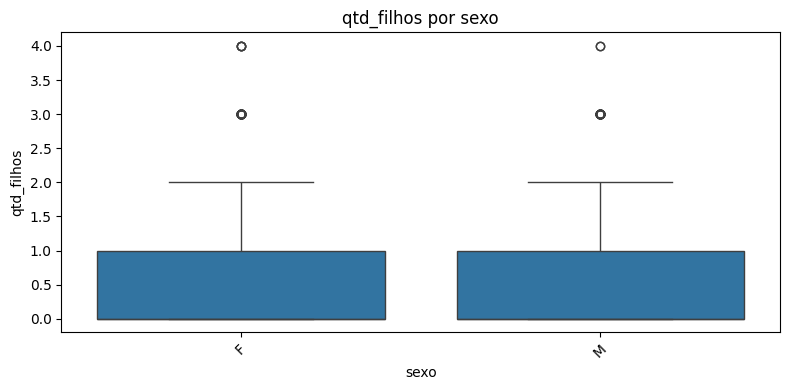

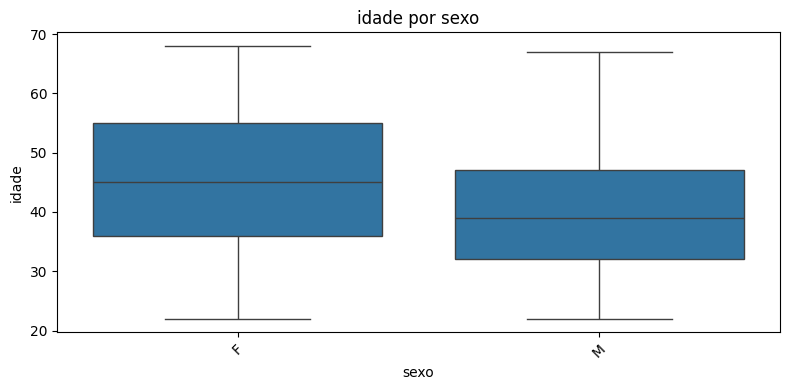

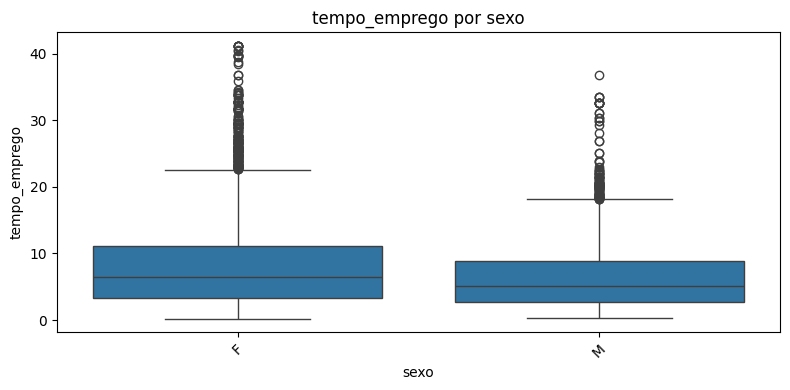

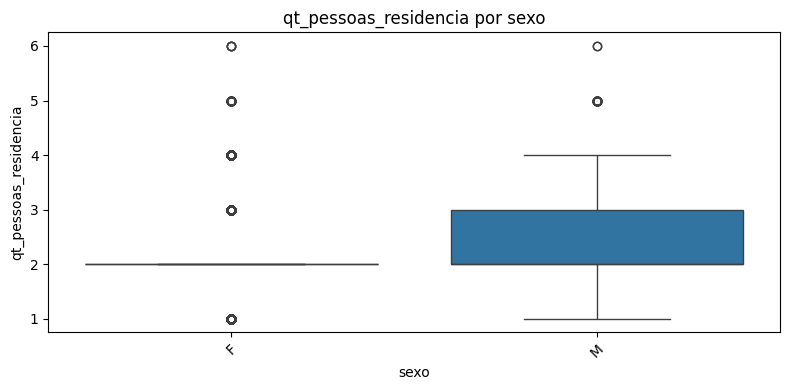

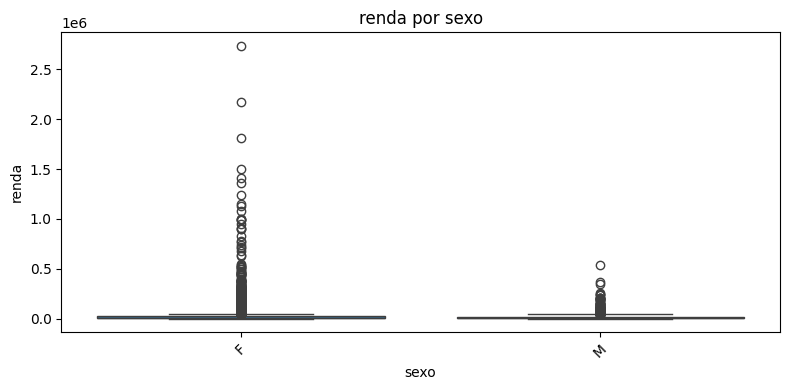

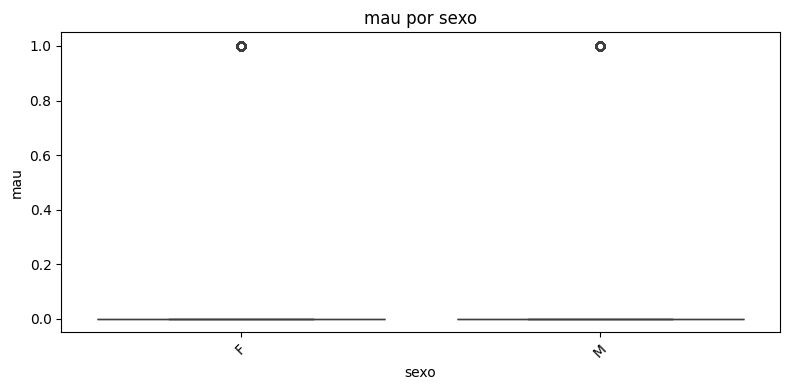

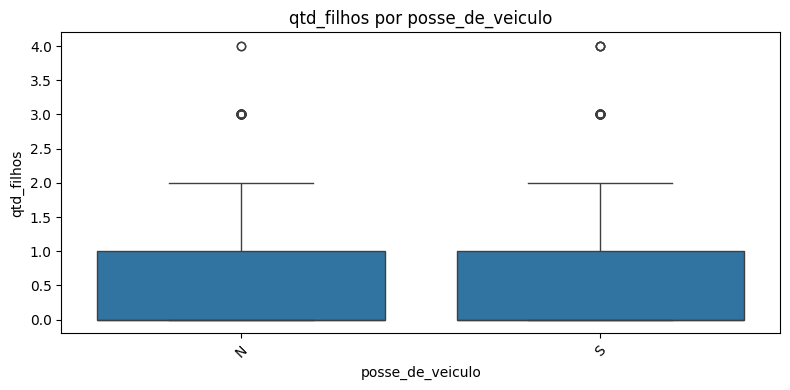

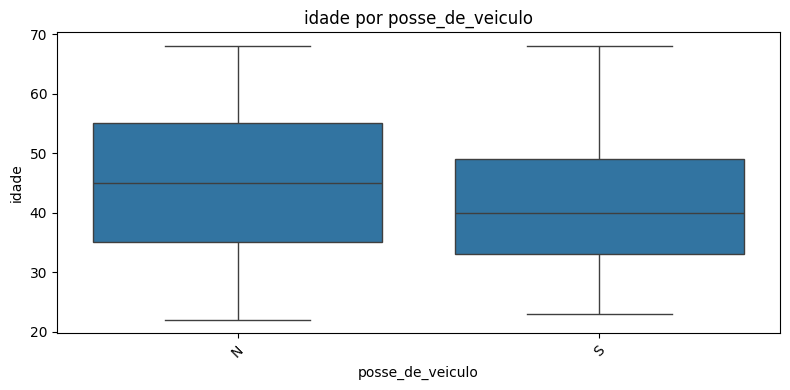

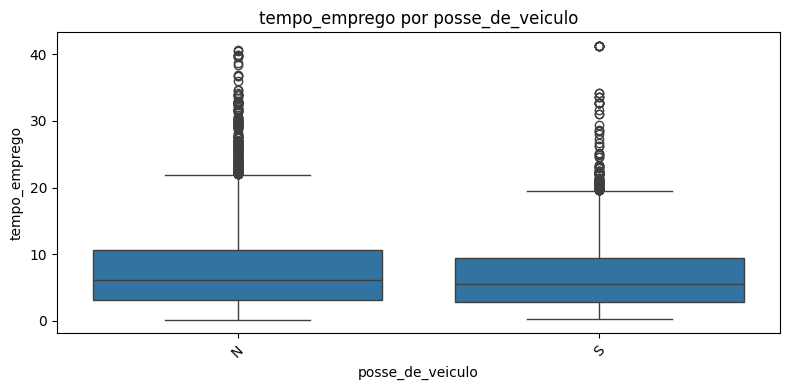

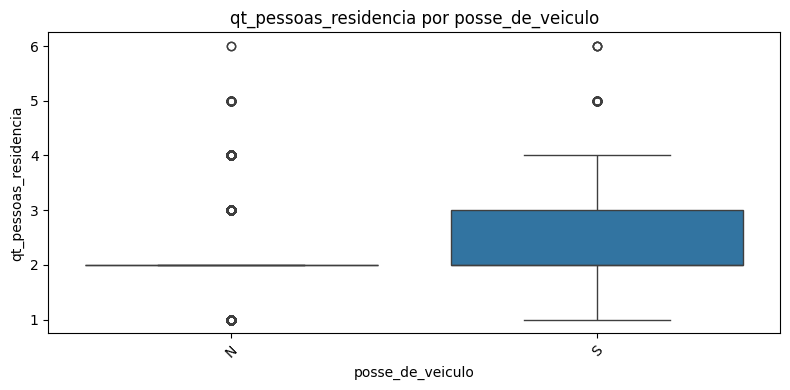

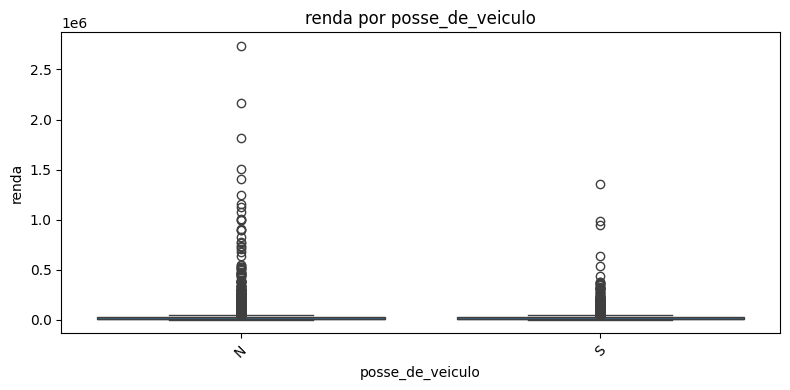

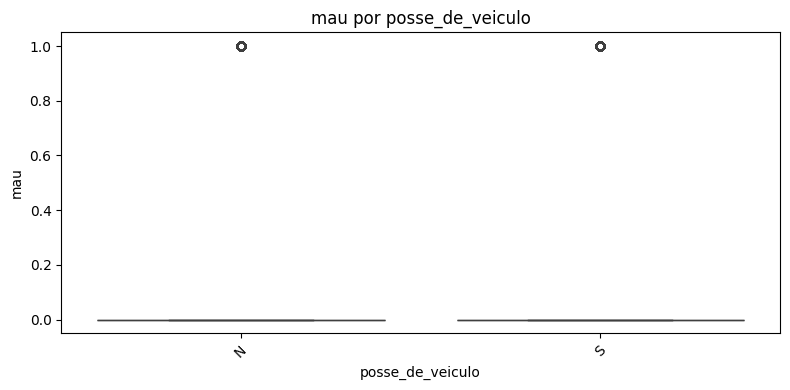

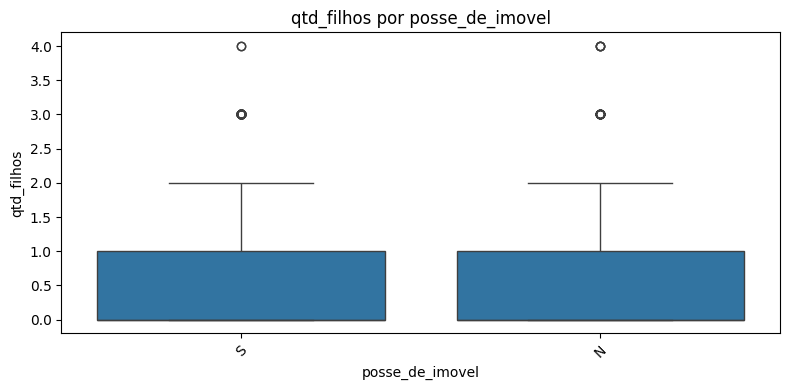

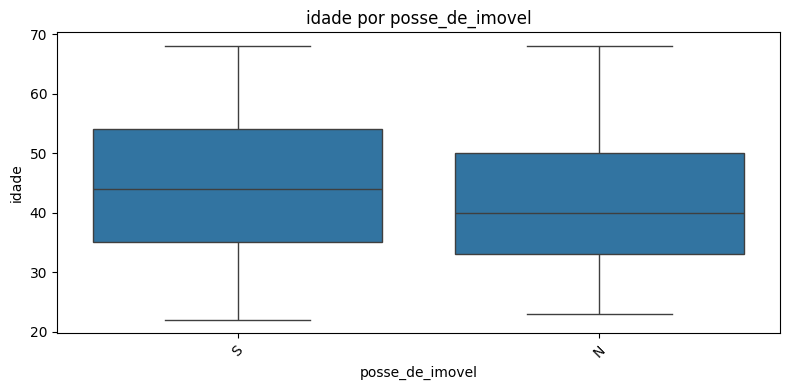

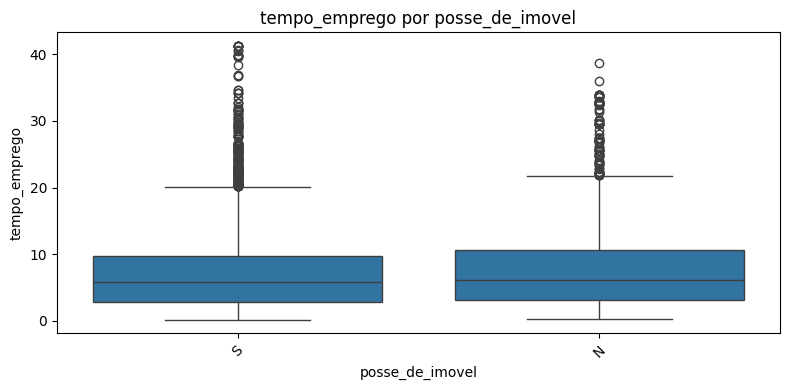

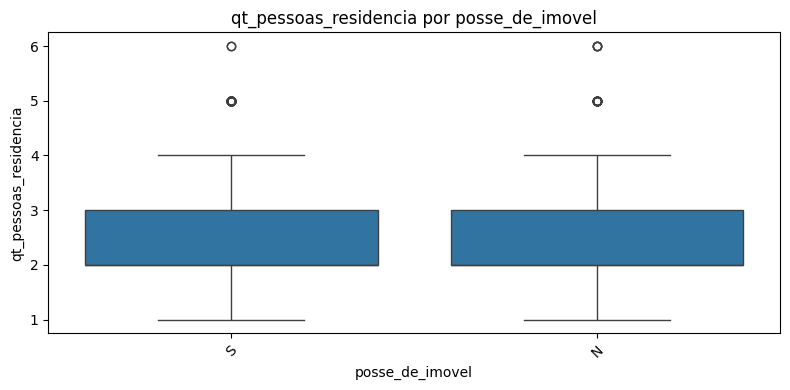

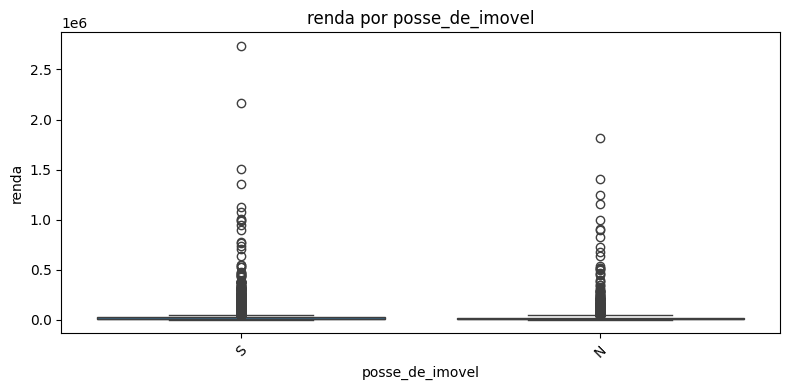

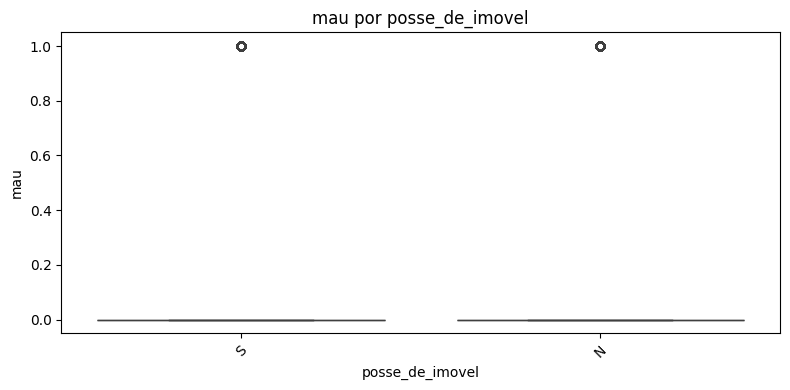

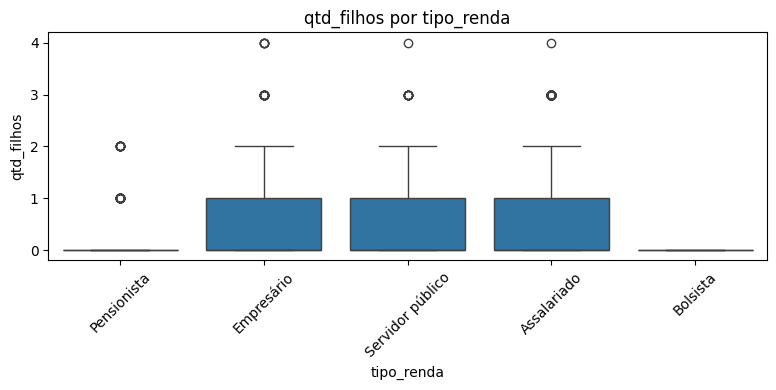

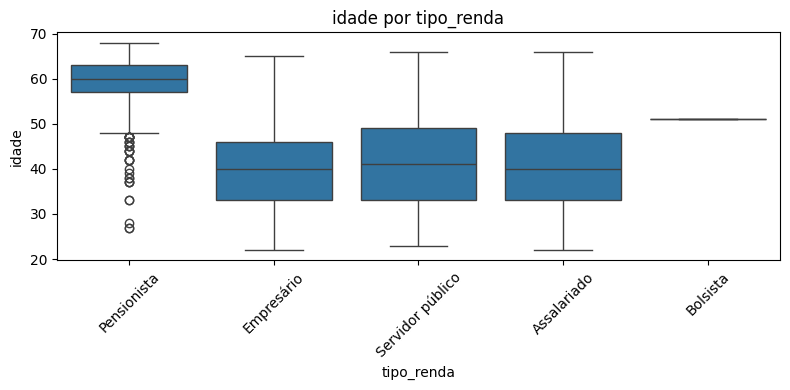

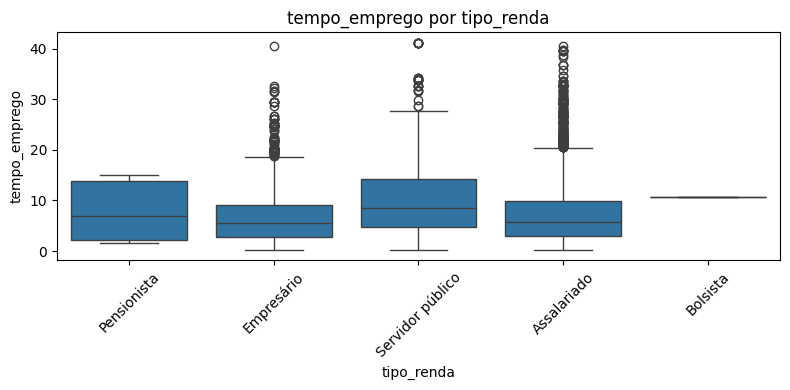

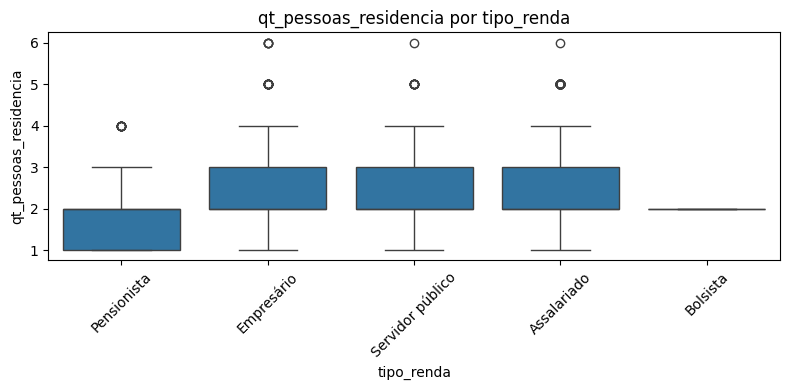

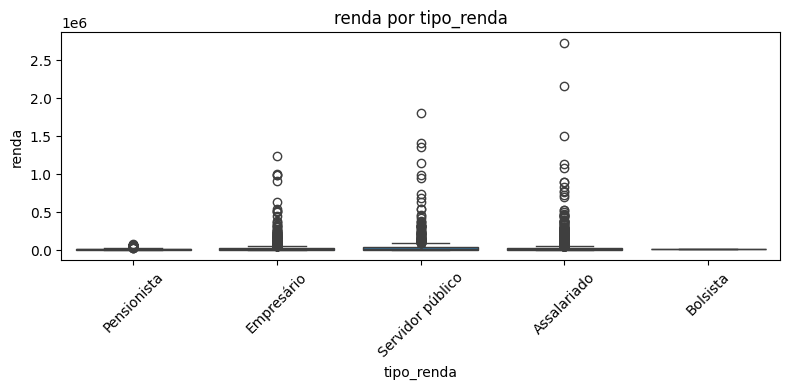

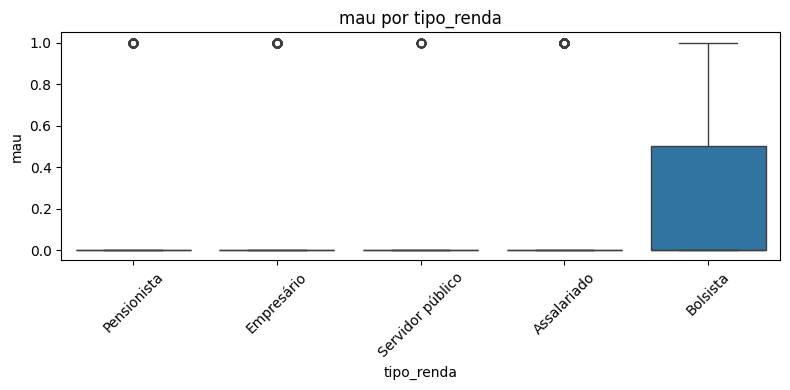

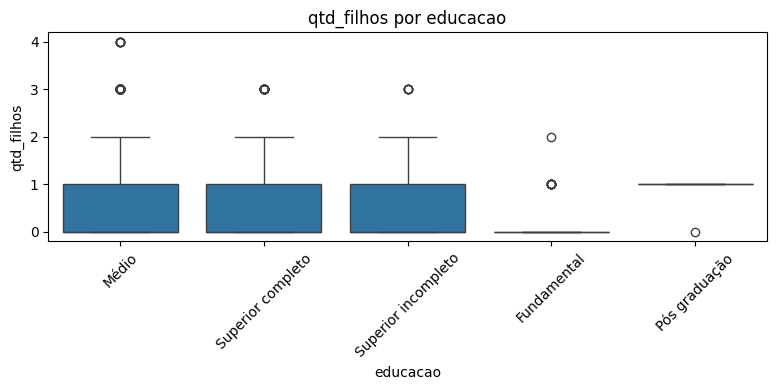

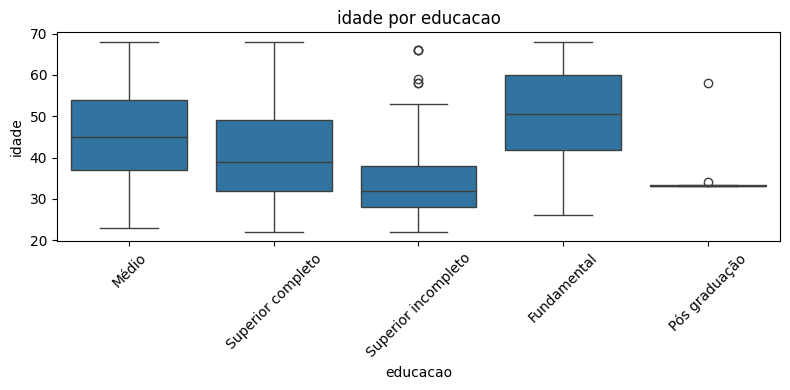

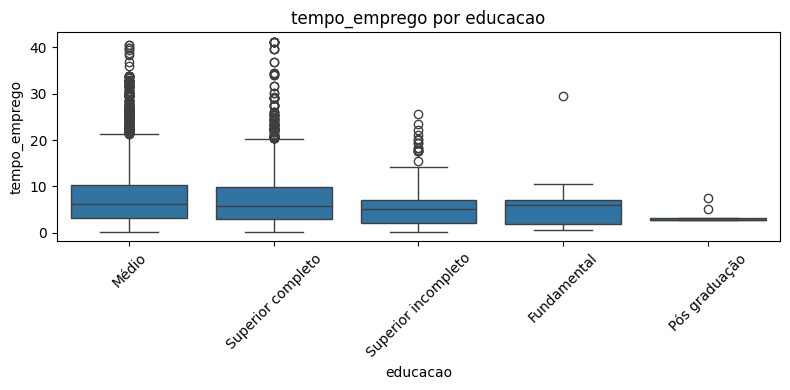

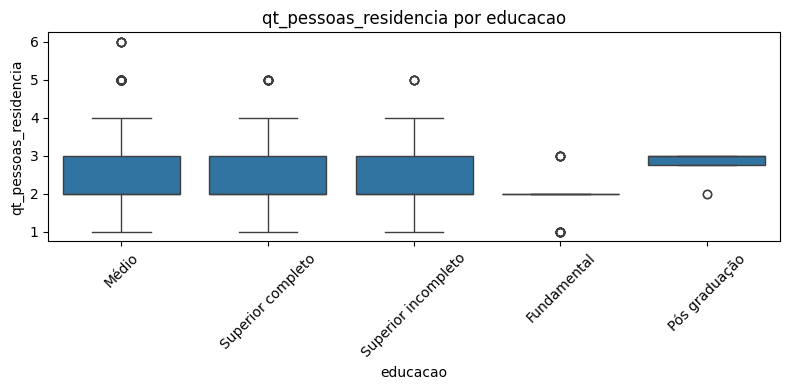

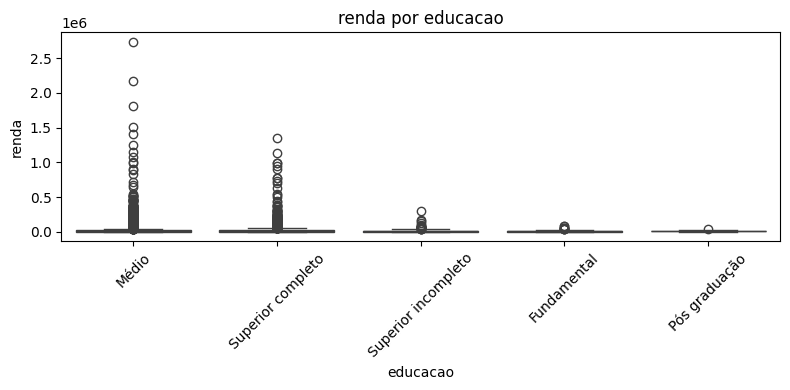

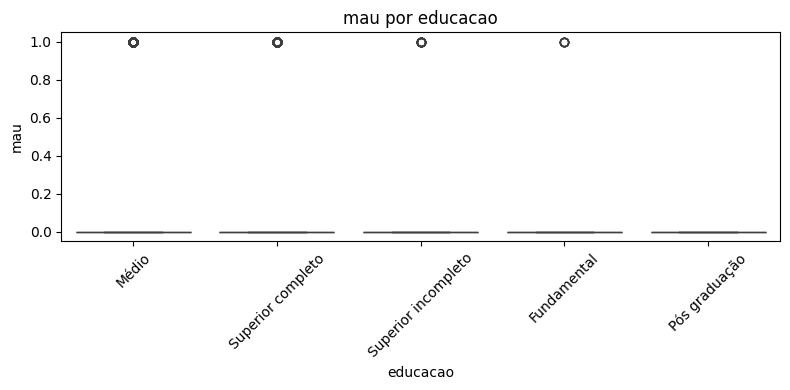

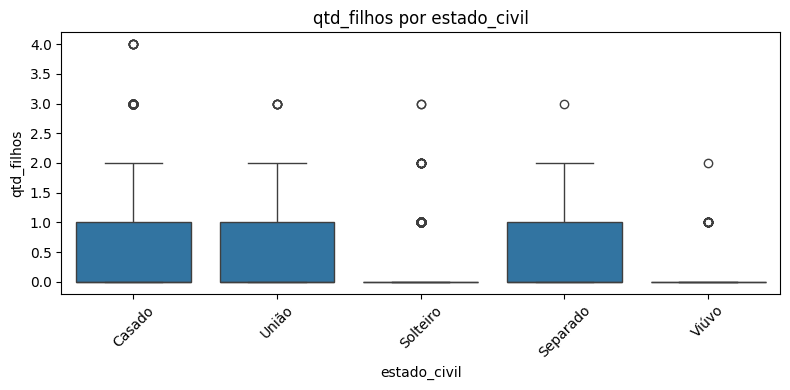

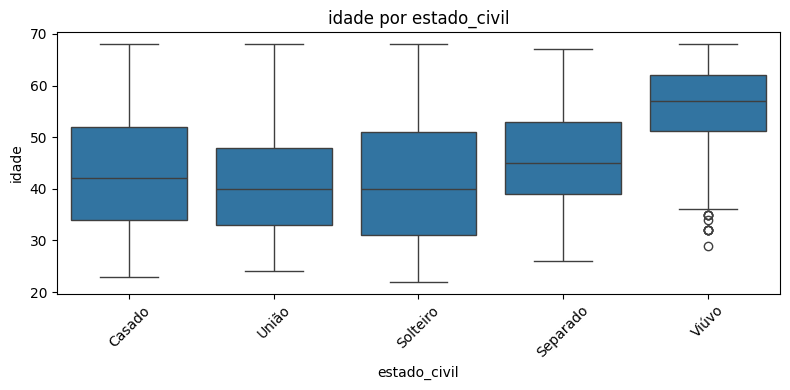

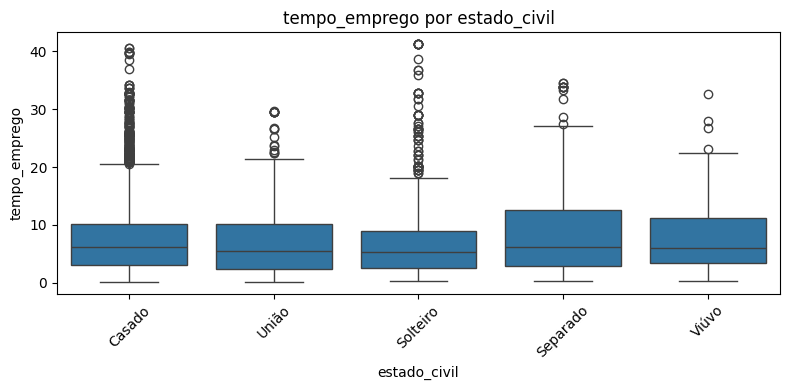

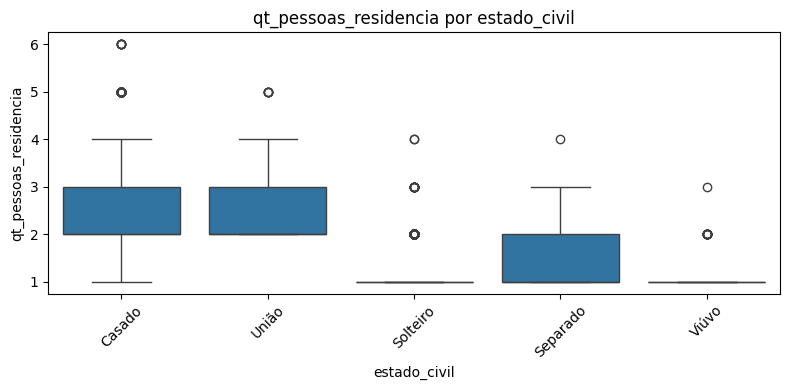

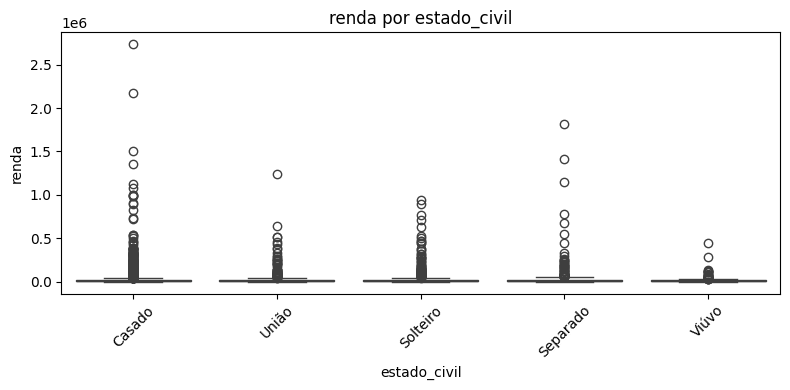

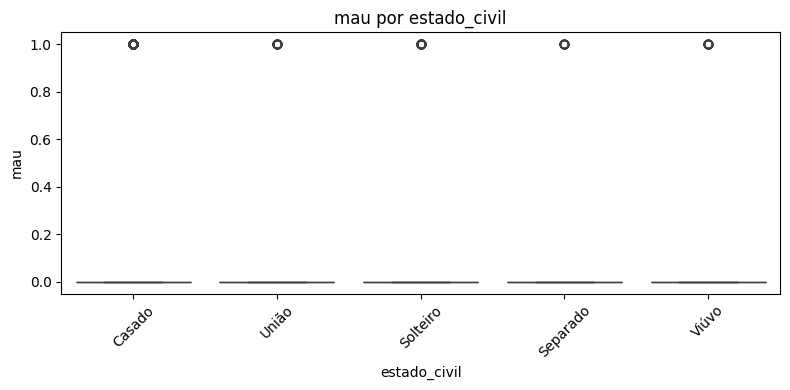

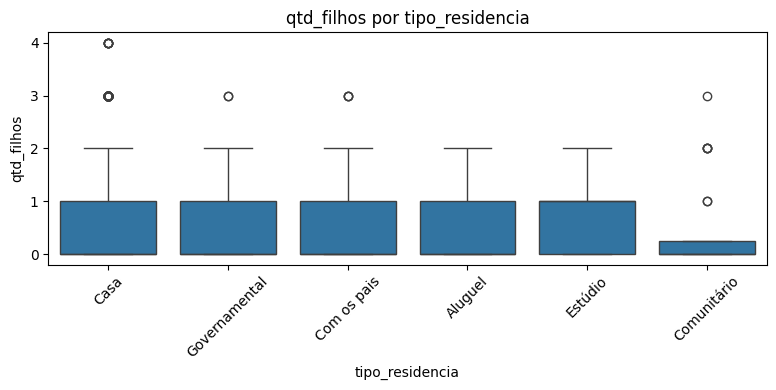

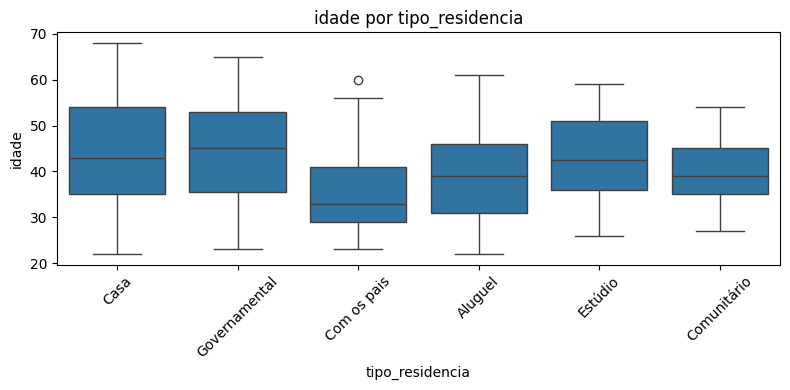

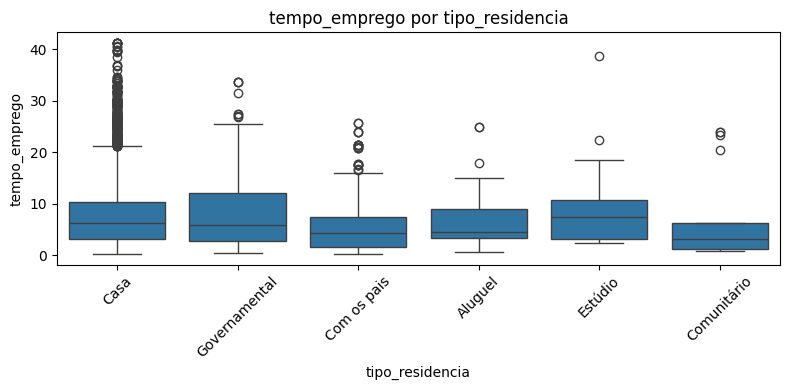

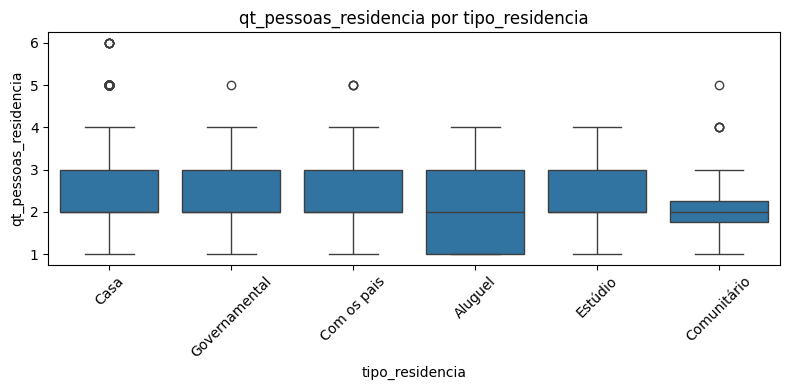

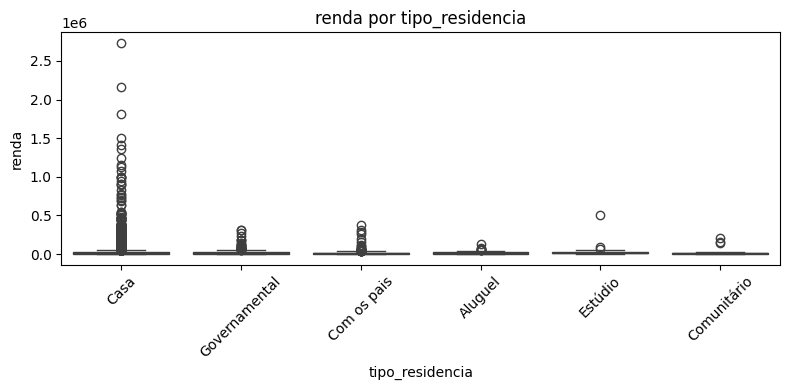

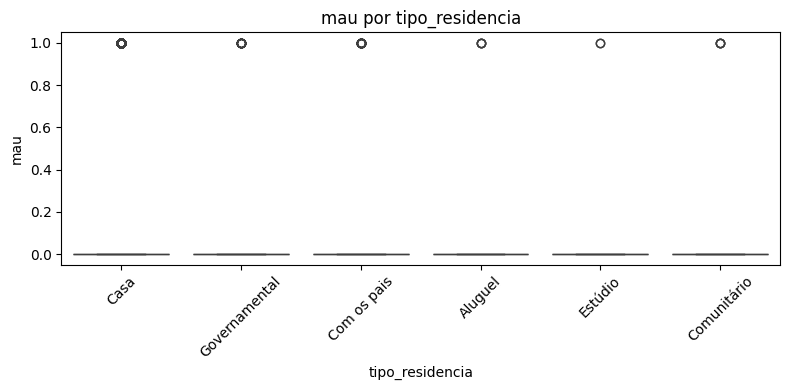

In [12]:
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
num_cols = df.select_dtypes(include=['number']).columns

# 1. Quantitativas × Quantitativas
print("\n=== Correlação entre variáveis numéricas ===")
correlacao = df[num_cols].corr().round(2)
print(correlacao)

# Opcional: mapa de calor de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(correlacao, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

# 2. Qualitativas × Qualitativas
print("\n=== Tabelas de Contingência (Qualitativas x Qualitativas) ===")
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        print(f"\n{col1} x {col2}")
        print(pd.crosstab(df[col1], df[col2]))

# 3. Qualitativas × Quantitativas
print("\n=== Médias de variáveis numéricas por categoria (Qualitativa x Quantitativa) ===")
for cat in cat_cols:
    for num in num_cols:
        print(f"\nMédia de {num} por categoria de {cat}")
        print(df.groupby(cat)[num].mean().round(2))

# Opcional: boxplots
for cat in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=cat, y=num, data=df)
        plt.title(f"{num} por {cat}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [13]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [14]:
# Discretizar a variável 'renda' em 5 categorias (quintis)

df['renda_bin'] = pd.qcut(df['renda'], q=5, duplicates='drop')


In [15]:
# Calcular o IV da variável discretizada

iv_renda = IV(df['renda_bin'], df['mau'])
print(f'IV da variável RENDA: {iv_renda:.1%}')

IV da variável RENDA: 97.9%


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [16]:
# atribuição de papéis

metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

dtype  nmissing  valores_unicos       papel
data_ref               datetime64[ns]       0.0            11.0  covariavel
sexo                           object       0.0             2.0  covariavel
posse_de_veiculo               object       0.0             2.0  covariavel
posse_de_imovel                object       0.0             2.0  covariavel
qtd_filhos                      int64       0.0             5.0  covariavel
tipo_renda                     object       0.0             5.0  covariavel
educacao                       object       0.0             5.0  covariavel
estado_civil                   object       0.0             5.0  covariavel
tipo_residencia                object       0.0             6.0  covariavel
idade                           int64       0.0            47.0  covariavel
tempo_emprego                 float64    1209.0          2176.0  covariavel
qt_pessoas_residencia         float64       0.0             6.0  covariavel
renda                         float64       0.0          7043.0  covariavel
mau                             int64       0.0             2.0    resposta
ano_mes                     period[M]       0.0            11.0  covariavel
renda_bin                    category       0.0             5.0  covariavel
bom                               NaN       NaN             NaN    resposta

In [17]:
# variável tempo_trabalho

var = 'tempo_emprego'

# Remove nulos das duas variáveis
df_temp = df[[var, 'mau']].dropna()

# Aplica o qcut com os dados sem nulos
IV(pd.qcut(df_temp[var], 5, duplicates='drop'), df_temp['mau'])

0.3522174408283616

In [18]:
# aplicando a função

for var in metadados[metadados.papel == 'covariavel'].index:
    # Seleciona somente as colunas necessárias e remove nulos
    df_temp = df[[var, 'mau']].dropna()

    # Se tiver muitos valores únicos, tenta aplicar qcut (somente se for numérica)
    if metadados.loc[var, 'valores_unicos'] > 6:
        if pd.api.types.is_numeric_dtype(df[var]):
            try:
                metadados.loc[var, 'IV'] = IV(pd.qcut(df_temp[var], 5, duplicates='drop'), df_temp['mau'])
            except:
                metadados.loc[var, 'IV'] = np.nan  # Se der erro, coloca NaN
        else:
            metadados.loc[var, 'IV'] = IV(df_temp[var], df_temp['mau'])
    else:
        metadados.loc[var, 'IV'] = IV(df_temp[var], df_temp['mau'])

metadados

dtype  nmissing  valores_unicos       papel  \
data_ref               datetime64[ns]       0.0            11.0  covariavel   
sexo                           object       0.0             2.0  covariavel   
posse_de_veiculo               object       0.0             2.0  covariavel   
posse_de_imovel                object       0.0             2.0  covariavel   
qtd_filhos                      int64       0.0             5.0  covariavel   
tipo_renda                     object       0.0             5.0  covariavel   
educacao                       object       0.0             5.0  covariavel   
estado_civil                   object       0.0             5.0  covariavel   
tipo_residencia                object       0.0             6.0  covariavel   
idade                           int64       0.0            47.0  covariavel   
tempo_emprego                 float64    1209.0          2176.0  covariavel   
qt_pessoas_residencia         float64       0.0             6.0  covariavel   
renda                         float64       0.0          7043.0  covariavel   
mau                             int64       0.0             2.0    resposta   
ano_mes                     period[M]       0.0            11.0  covariavel   
renda_bin                    category       0.0             5.0  covariavel   
bom                               NaN       NaN             NaN    resposta   

                             IV  
data_ref               0.345259  
sexo                   0.003850  
posse_de_veiculo       0.005461  
posse_de_imovel        0.002655  
qtd_filhos                  inf  
tipo_renda             0.020676  
educacao                    inf  
estado_civil           0.014242  
tipo_residencia        0.013174  
idade                  0.060317  
tempo_emprego          0.352217  
qt_pessoas_residencia       inf  
renda                  0.978532  
mau                         NaN  
ano_mes                0.345259  
renda_bin              0.978532  
bom                         NaN

In [19]:
# bivariada

def biv_discreta(var, df):
    # Cria variável 'bom' como complemento de 'mau'
    df['bom'] = 1 - df['mau']
    
    # Agrupamento
    g = df.groupby(var)

    # Monta a tabela resumo bivariada
    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont': g[var].count()
    })

    # Erro padrão e intervalos de confiança da taxa de mau
    biv['ep'] = np.sqrt(biv['mau'] * (1 - biv['mau']) / biv['cont'])
    biv['mau_sup'] = biv['mau'] + t.ppf(0.975, biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] + t.ppf(0.025, biv['cont'] - 1) * biv['ep']

    # Corrigir limites fora de [0, 1]
    biv['mau_sup'] = biv['mau_sup'].clip(upper=1 - 1e-6)
    biv['mau_inf'] = biv['mau_inf'].clip(lower=1e-6)

    # Calcular logito com proteção contra log(0)
    epsilon = 1e-6
    biv['logit'] = np.log((biv['mau'] + epsilon) / (1 - biv['mau'] + epsilon))
    biv['logit_sup'] = np.log((biv['mau_sup'] + epsilon) / (1 - biv['mau_sup'] + epsilon))
    biv['logit_inf'] = np.log((biv['mau_inf'] + epsilon) / (1 - biv['mau_inf'] + epsilon))

    # WOE em relação à taxa de mau geral
    tx_mau_geral = df['mau'].mean()
    woe_geral = np.log((tx_mau_geral + epsilon) / (1 - tx_mau_geral + epsilon))

    biv['woe'] = biv['logit'] - woe_geral
    biv['woe_sup'] = biv['logit_sup'] - woe_geral
    biv['woe_inf'] = biv['logit_inf'] - woe_geral

    # Gráficos
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    ax[0].plot(biv[var], biv['woe'], ':bo', label='WOE')
    ax[0].plot(biv[var], biv['woe_sup'], 'o:r', label='Limite superior')
    ax[0].plot(biv[var], biv['woe_inf'], 'o:r', label='Limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-0.3, num_cat - 0.7])
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv['cont'].plot.bar()
    ax[1].set_ylabel("Contagem")

    plt.tight_layout()
    plt.show()

    return biv

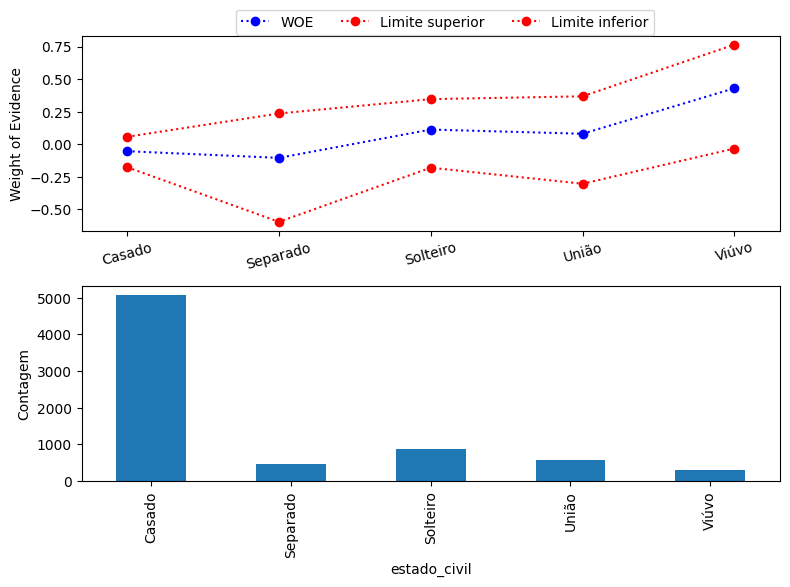

In [20]:
biv_discreta('estado_civil', df);

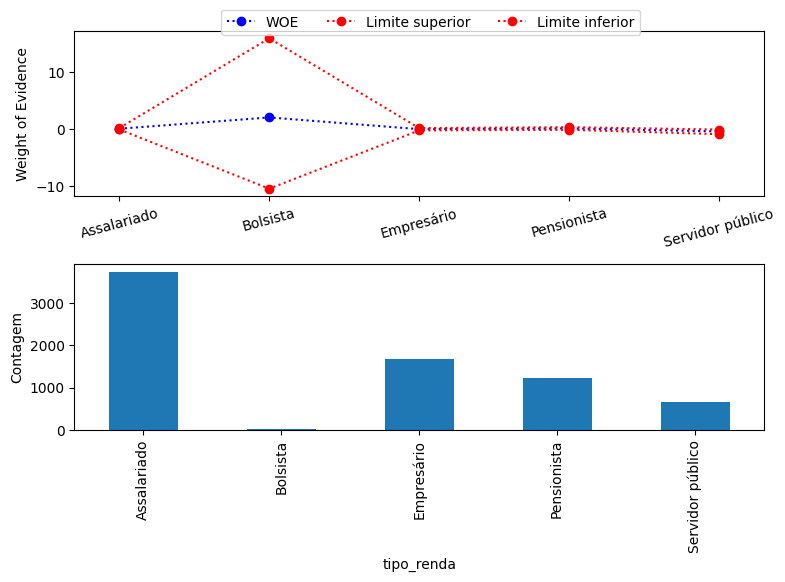

qt_bom  qt_mau       mau        tipo_renda  cont        ep  \
tipo_renda                                                                     
Assalariado         3502     245  0.065386       Assalariado  3747  0.004038   
Bolsista               2       1  0.333333          Bolsista     3  0.272166   
Empresário          1577     102  0.060750        Empresário  1679  0.005830   
Pensionista         1131      84  0.069136       Pensionista  1215  0.007278   
Servidor público     621      27  0.041667  Servidor público   648  0.007850   

                   mau_sup   mau_inf     logit  logit_sup  logit_inf  \
tipo_renda                                                             
Assalariado       0.073303  0.057468 -2.659817  -2.537006  -2.797328   
Bolsista          0.999999  0.000001 -0.693146  13.122363 -13.122363   
Empresário        0.072185  0.049316 -2.738291  -2.553594  -2.958906   
Pensionista       0.083414  0.054857 -2.600027  -2.396823  -2.846587   
Servidor público  0.057081  0.026252 -3.135471  -2.804491  -3.613363   

                       woe    woe_sup    woe_inf  
tipo_renda                                        
Assalariado       0.040637   0.163448  -0.096874  
Bolsista          2.007308  15.822817 -10.421909  
Empresário       -0.037837   0.146860  -0.258452  
Pensionista       0.100427   0.303631  -0.146133  
Servidor público -0.435017  -0.104037  -0.912909

In [21]:
biv_discreta('tipo_renda', df)

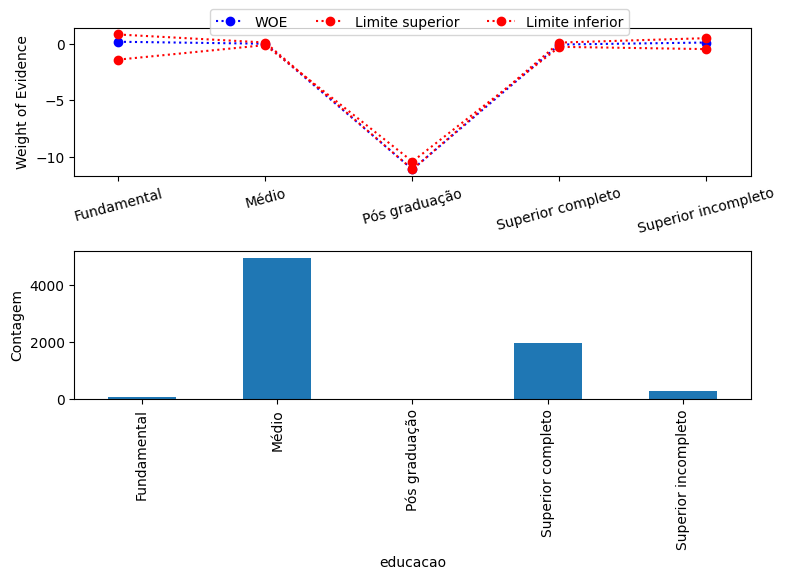

qt_bom  qt_mau       mau             educacao  cont  \
educacao                                                                   
Fundamental              74       6  0.075000          Fundamental    80   
Médio                  4643     316  0.063723                Médio  4959   
Pós graduação             8       0  0.000000        Pós graduação     8   
Superior completo      1844     117  0.059663    Superior completo  1961   
Superior incompleto     264      20  0.070423  Superior incompleto   284   

                           ep   mau_sup   mau_inf      logit  logit_sup  \
educacao                                                                  
Fundamental          0.029448  0.133615  0.016385  -2.512293  -1.869362   
Médio                0.003469  0.070522  0.056923  -2.687359  -2.578678   
Pós graduação        0.000000  0.000000  0.000001 -13.815512 -13.815512   
Superior completo    0.005349  0.070153  0.049173  -2.757503  -2.584322   
Superior incompleto  0.015182  0.100307  0.040538  -2.580204  -2.193807   

                     logit_inf        woe    woe_sup    woe_inf  
educacao                                                         
Fundamental          -4.094800   0.188161   0.831092  -1.394346  
Médio                -2.807440   0.013095   0.121776  -0.106986  
Pós graduação       -13.122363 -11.115057 -11.115057 -10.421909  
Superior completo    -2.961958  -0.057049   0.116132  -0.261504  
Superior incompleto  -3.164113   0.120250   0.506647  -0.463659

In [22]:
biv_discreta('educacao', df)

In [23]:
# bivariada contínua

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\Cristina\AppData\Local\Temp\ipykernel_6444\1830931355.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


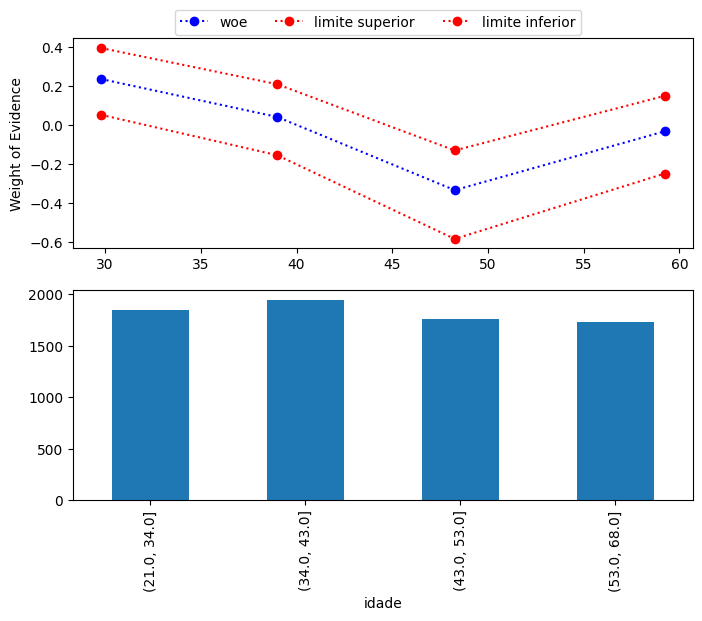

In [24]:
biv_continua('idade', 4, df)

C:\Users\Cristina\AppData\Local\Temp\ipykernel_6444\1830931355.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


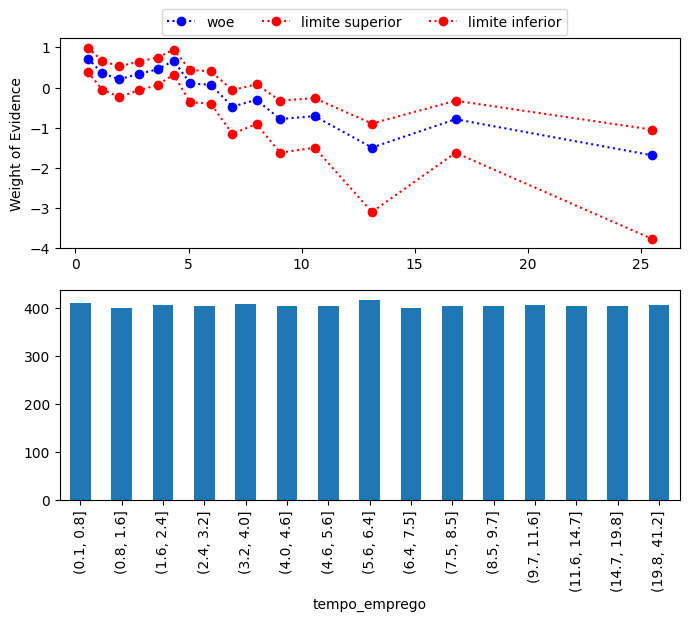

In [25]:
df2 = df
df2.loc[df['tempo_emprego']<0,'tempo_emprego'] = -1
biv_continua('tempo_emprego', 15, df2)

C:\Users\Cristina\AppData\Local\Temp\ipykernel_6444\1830931355.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


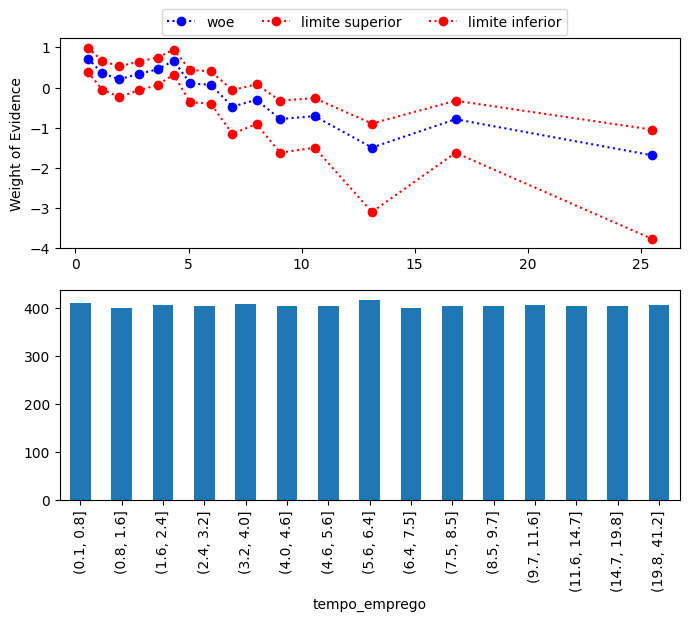

In [26]:
df2.loc[df2['tempo_emprego']<0,'tempo_emprego'] = -1
biv_continua('tempo_emprego', 15, df2)

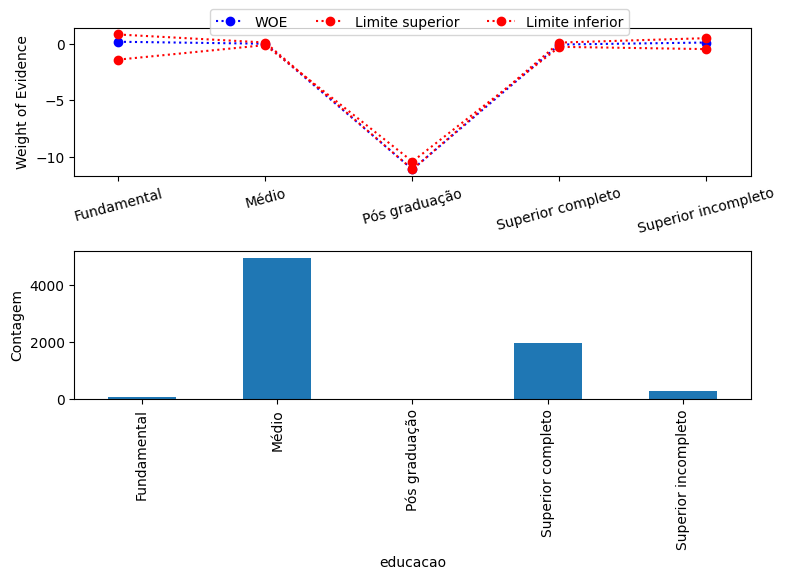

qt_bom  qt_mau       mau             educacao  cont  \
educacao                                                                   
Fundamental              74       6  0.075000          Fundamental    80   
Médio                  4643     316  0.063723                Médio  4959   
Pós graduação             8       0  0.000000        Pós graduação     8   
Superior completo      1844     117  0.059663    Superior completo  1961   
Superior incompleto     264      20  0.070423  Superior incompleto   284   

                           ep   mau_sup   mau_inf      logit  logit_sup  \
educacao                                                                  
Fundamental          0.029448  0.133615  0.016385  -2.512293  -1.869362   
Médio                0.003469  0.070522  0.056923  -2.687359  -2.578678   
Pós graduação        0.000000  0.000000  0.000001 -13.815512 -13.815512   
Superior completo    0.005349  0.070153  0.049173  -2.757503  -2.584322   
Superior incompleto  0.015182  0.100307  0.040538  -2.580204  -2.193807   

                     logit_inf        woe    woe_sup    woe_inf  
educacao                                                         
Fundamental          -4.094800   0.188161   0.831092  -1.394346  
Médio                -2.807440   0.013095   0.121776  -0.106986  
Pós graduação       -13.122363 -11.115057 -11.115057 -10.421909  
Superior completo    -2.961958  -0.057049   0.116132  -0.261504  
Superior incompleto  -3.164113   0.120250   0.506647  -0.463659

In [27]:
biv_discreta('educacao', df2)

In [28]:
formula = '''
    mau ~ C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) +
    qtd_filhos + C(tipo_renda) + C(educacao) + C(estado_civil) +
    C(tipo_residencia) + idade + tempo_emprego + 
    qt_pessoas_residencia + renda
'''

# Ajuste do modelo
modelo = smf.glm(formula=formula, data=df2, family=sm.families.Binomial()).fit()

# Sumário dos resultados
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                 6083
Model:                            GLM   Df Residuals:                     6057
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1254.0
Date:                Sat, 12 Jul 2025   Deviance:                       2507.9
Time:                        10:47:27   Pearson chi2:                 1.03e+06
No. Iterations:                    21   Pseudo R-squ. (CS):            0.05026
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -2.1032      2.991     -0.703      0.482      -7.966       3.759
C(sexo)[T.M]                           -0.0652      0.125     -0.523      0.601      -0.310       0.179
C(posse_de_veiculo)[T.S]               -0.1596      0.120     -1.327      0.184      -0.395       0.076
C(posse_de_imovel)[T.S]                -0.0404      0.116     -0.349      0.727      -0.268       0.187
C(tipo_renda)[T.Bolsista]               2.3884      1.247      1.916      0.055      -0.055       4.832
C(tipo_renda)[T.Empresário]            -0.0108      0.127     -0.085      0.932      -0.259       0.237
C(tipo_renda)[T.Pensionista]            0.7341      1.136      0.646      0.518      -1.492       2.960
C(tipo_renda)[T.Servidor público]      -0.1839      0.215     -0.857      0.392      -0.605       0.237
C(educacao)[T.Médio]                   -0.0052      0.551     -0.009      0.993      -1.084       1.074
C(educacao)[T.Pós graduação]          -19.8751   1.66e+04     -0.001      0.999   -3.26e+04    3.26e+04
C(educacao)[T.Superior completo]       -0.0662      0.557     -0.119      0.905      -1.159       1.026
C(educacao)[T.Superior incompleto]     -0.0160      0.598     -0.027      0.979      -1.189       1.157
C(estado_civil)[T.Separado]             0.2475      1.461      0.169      0.865      -2.616       3.111
C(estado_civil)[T.Solteiro]             0.4469      1.447      0.309      0.757      -2.390       3.284
C(estado_civil)[T.União]                0.2076      0.194      1.072      0.284      -0.172       0.587
C(estado_civil)[T.Viúvo]                0.7028      1.479      0.475      0.635      -2.197       3.602
C(tipo_residencia)[T.Casa]              0.4911      0.525      0.936      0.349      -0.538       1.520
C(tipo_residencia)[T.Com os pais]       0.5744      0.560      1.025      0.305      -0.524       1.673
C(tipo_residencia)[T.Comunitário]       1.3471      0.777      1.734      0.083      -0.175       2.869
C(tipo_residencia)[T.Estúdio]          -0.0532      1.155     -0.046      0.963      -2.317       2.210
C(tipo_residencia)[T.Governamental]     0.5828      0.600      0.972      0.331      -0.593       1.758
qtd_filhos                             -0.2294      1.442     -0.159      0.874      -3.055       2.596
idade                                  -0.0128      0.007     -1.896      0.058      -0.026       0.000
tempo_emprego                          -0.0031      0.016     -0.193      0.847      -0.035       0.029
qt_pessoas_residencia                   0.2736      1.441      0.190      0.849      -2.551       3.098
renda                                  -0.0001   1.06e-05     -9.802      0.000      -0.000   -8.32e-05
===================================================================

In [29]:
metadados.sort_values(by='IV', ascending=False)

dtype  nmissing  valores_unicos       papel  \
qtd_filhos                      int64       0.0             5.0  covariavel   
educacao                       object       0.0             5.0  covariavel   
qt_pessoas_residencia         float64       0.0             6.0  covariavel   
renda                         float64       0.0          7043.0  covariavel   
renda_bin                    category       0.0             5.0  covariavel   
tempo_emprego                 float64    1209.0          2176.0  covariavel   
data_ref               datetime64[ns]       0.0            11.0  covariavel   
ano_mes                     period[M]       0.0            11.0  covariavel   
idade                           int64       0.0            47.0  covariavel   
tipo_renda                     object       0.0             5.0  covariavel   
estado_civil                   object       0.0             5.0  covariavel   
tipo_residencia                object       0.0             6.0  covariavel   
posse_de_veiculo               object       0.0             2.0  covariavel   
sexo                           object       0.0             2.0  covariavel   
posse_de_imovel                object       0.0             2.0  covariavel   
mau                             int64       0.0             2.0    resposta   
bom                               NaN       NaN             NaN    resposta   

                             IV  
qtd_filhos                  inf  
educacao                    inf  
qt_pessoas_residencia       inf  
renda                  0.978532  
renda_bin              0.978532  
tempo_emprego          0.352217  
data_ref               0.345259  
ano_mes                0.345259  
idade                  0.060317  
tipo_renda             0.020676  
estado_civil           0.014242  
tipo_residencia        0.013174  
posse_de_veiculo       0.005461  
sexo                   0.003850  
posse_de_imovel        0.002655  
mau                         NaN  
bom                         NaN

In [30]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'qtd_filhos + educacao + qt_pessoas_residencia + renda + renda_bin + tempo_emprego + data_ref + ano_mes + idade + tipo_renda + estado_civil + tipo_residencia + posse_de_veiculo + sexo + posse_de_imovel + mau + bom'

In [31]:
formula = '''
    mau ~ tempo_emprego + estado_civil 
    + idade + posse_de_imovel + tipo_residencia 
    + educacao
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                 6083
Model:                            GLM   Df Residuals:                     6066
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1347.8
Date:                Sat, 12 Jul 2025   Deviance:                       2695.6
Time:                        10:47:36   Pearson chi2:                 6.14e+03
No. Iterations:                    21   Pseudo R-squ. (CS):            0.02049
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.7808      0.779     -2.287      0.022      -3.307      -0.254
estado_civil[T.Separado]             0.0262      0.238      0.110      0.912      -0.439       0.492
estado_civil[T.Solteiro]             0.1224      0.158      0.775      0.438      -0.187       0.432
estado_civil[T.União]                0.1241      0.189      0.656      0.512      -0.247       0.495
estado_civil[T.Viúvo]                0.4967      0.320      1.551      0.121      -0.131       1.125
posse_de_imovel[T.S]                -0.1676      0.114     -1.477      0.140      -0.390       0.055
tipo_residencia[T.Casa]              0.4609      0.518      0.890      0.373      -0.554       1.476
tipo_residencia[T.Com os pais]       0.5620      0.553      1.017      0.309      -0.521       1.645
tipo_residencia[T.Comunitário]       1.1713      0.757      1.546      0.122      -0.313       2.656
tipo_residencia[T.Estúdio]          -0.2294      1.144     -0.201      0.841      -2.471       2.012
tipo_residencia[T.Governamental]     0.4407      0.592      0.745      0.456      -0.719       1.600
educacao[T.Médio]                   -0.0113      0.535     -0.021      0.983      -1.060       1.037
educacao[T.Pós graduação]          -20.1510    1.7e+04     -0.001      0.999   -3.33e+04    3.33e+04
educacao[T.Superior completo]       -0.1623      0.541     -0.300      0.764      -1.222       0.897
educacao[T.Superior incompleto]     -0.1309      0.582     -0.225      0.822      -1.272       1.010
tempo_emprego                       -0.1100      0.014     -8.146      0.000      -0.137      -0.084
idade                               -0.0156      0.006     -2.441      0.015      -0.028      -0.003
====================================================================================================
"""

In [32]:
# ETAPA 1: Prever os scores com o modelo treinado

df2['score'] = rl.predict(df2)

# ETAPA 2: Remover registros com valores ausentes em 'mau' ou 'score'
df_avaliacao = df2[['mau', 'score']].dropna()

# ETAPA 3: Calcular métricas

# Acurácia com threshold de 0.068
acc = metrics.accuracy_score(df_avaliacao['mau'], df_avaliacao['score'] > 0.068)

# Curva ROC e AUC
fpr, tpr, thresholds = metrics.roc_curve(df_avaliacao['mau'], df_avaliacao['score'])
auc = metrics.auc(fpr, tpr)

# GINI
gini = 2 * auc - 1

# KS (Kolmogorov-Smirnov)
ks = ks_2samp(
    df_avaliacao.loc[df_avaliacao.mau == 1, 'score'],
    df_avaliacao.loc[df_avaliacao.mau != 1, 'score']
).statistic

# ETAPA 4: Exibir os resultados
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%} \nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 60.6% 
AUC: 66.5% 
GINI: 33.1% 
KS: 26.6%


In [33]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    return tg[['distribuição', score, 'tx_ev']]



C:\Users\Cristina\AppData\Local\Temp\ipykernel_6444\2325786389.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))


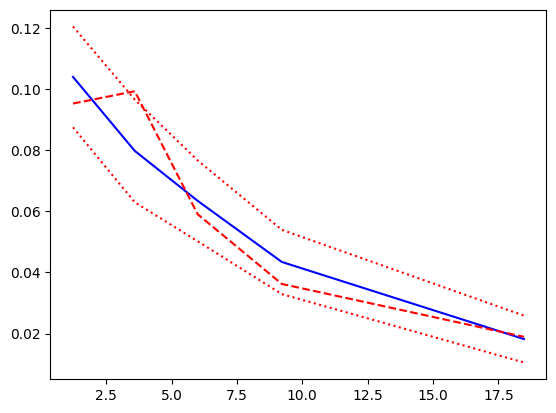

In [34]:
tg = perfil_var(df2, 'tempo_emprego', ncat=5)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

C:\Users\Cristina\AppData\Local\Temp\ipykernel_6444\2325786389.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))


distribuição     score     tx_ev
idade                                           
(21.999, 33.0]      0.227510  0.083786  0.083183
(33.0, 39.0]        0.173615  0.064433  0.064771
(39.0, 46.0]        0.199259  0.055517  0.059876
(46.0, 55.0]        0.205979  0.046305  0.040613
(55.0, 68.0]        0.193637  0.036587  0.064448

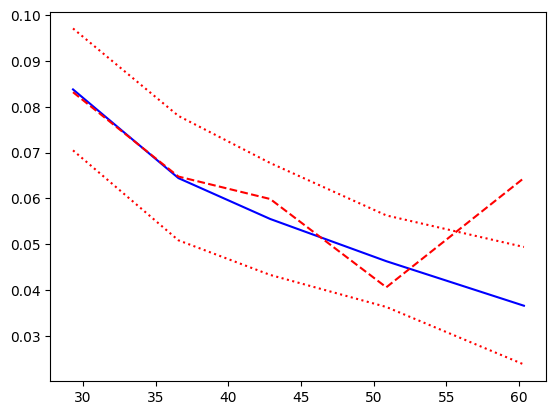

In [35]:
tg = perfil_var(df2, 'idade', ncat=5)
tg

C:\Users\Cristina\AppData\Local\Temp\ipykernel_6444\2325786389.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))


distribuição     score     tx_ev
score                                                       
(-0.0009999999075, 0.0316]      0.200066  0.017263  0.019721
(0.0316, 0.0516]                0.200066  0.041655  0.032046
(0.0516, 0.0689]                0.200230  0.060241  0.068966
(0.0689, 0.0906]                0.200066  0.079583  0.079704
(0.0906, 0.252]                 0.199573  0.110436  0.108731

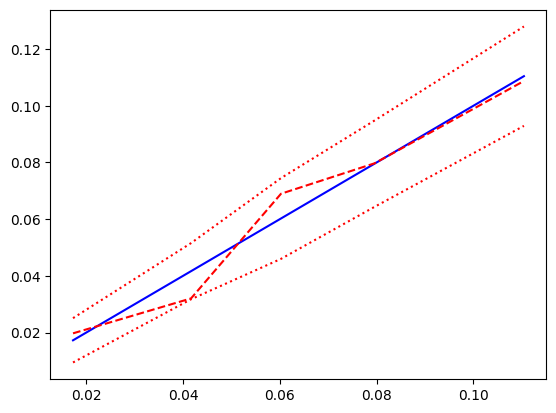

In [36]:
perfil_var(df2, 'score', ncat=5)

In [37]:
df3 = df2.sort_values(by='score').reset_index().copy()
df3['tx_mau_acum'] = df3.mau.cumsum()/df3.shape[0]

df3['pct_mau_acum'] = df3.mau.cumsum()/df3.mau.sum()
df3['red_mau_acum'] = 1-df3.pct_mau_acum

df3['pct_aprovacao'] = np.array(range(df3.shape[0]))/df3.shape[0]
df3.head()

index   data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0  488943 2015-10-01    M                N               S           0   
1  219644 2015-05-01    F                N               S           1   
2  193523 2015-04-01    F                S               S           1   
3  372239 2015-08-01    F                S               S           1   
4  410239 2015-09-01    F                S               S           1   

    tipo_renda       educacao estado_civil tipo_residencia  ...     renda  \
0   Empresário  Pós graduação       Casado            Casa  ...  35477.22   
1  Assalariado  Pós graduação     Solteiro            Casa  ...  20387.52   
2   Empresário  Pós graduação       Casado            Casa  ...   7288.22   
3   Empresário  Pós graduação       Casado            Casa  ...  12306.62   
4   Empresário  Pós graduação       Casado            Casa  ...   5608.13   

   mau  ano_mes                renda_bin  bom         score tx_mau_acum  \
0    0  2015-10  (28010.372, 2734494.51]    1  9.251544e-11         0.0   
1    0  2015-05   (13733.572, 28010.372]    1  1.154587e-10         0.0   
2    0  2015-04     (4100.062, 7927.126]    1  1.779990e-10         0.0   
3    0  2015-08    (7927.126, 13733.572]    1  1.779990e-10         0.0   
4    0  2015-09     (4100.062, 7927.126]    1  1.779990e-10         0.0   

   pct_mau_acum  red_mau_acum  pct_aprovacao  
0           0.0           1.0       0.000000  
1           0.0           1.0       0.000137  
2           0.0           1.0       0.000274  
3           0.0           1.0       0.000411  
4           0.0           1.0       0.000549  

[5 rows x 23 columns]

C:\Users\Cristina\anaconda3\Lib\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




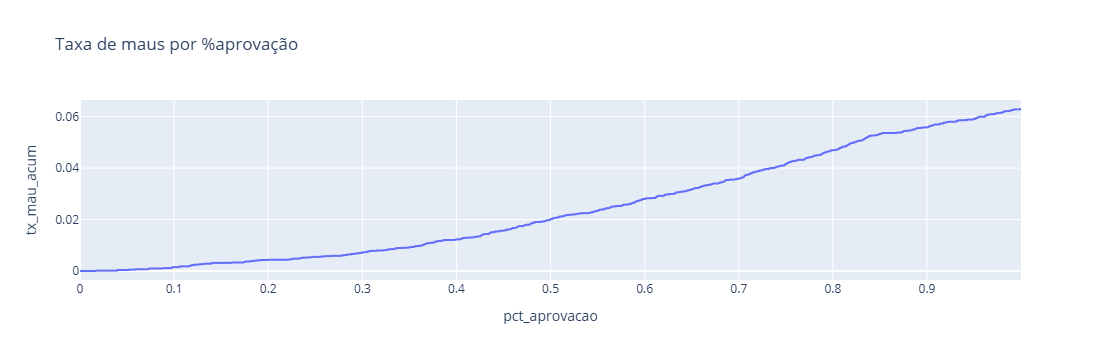

In [38]:
fig = px.line(df3, x="pct_aprovacao", y="tx_mau_acum", title='Taxa de maus por %aprovação')
fig.show()

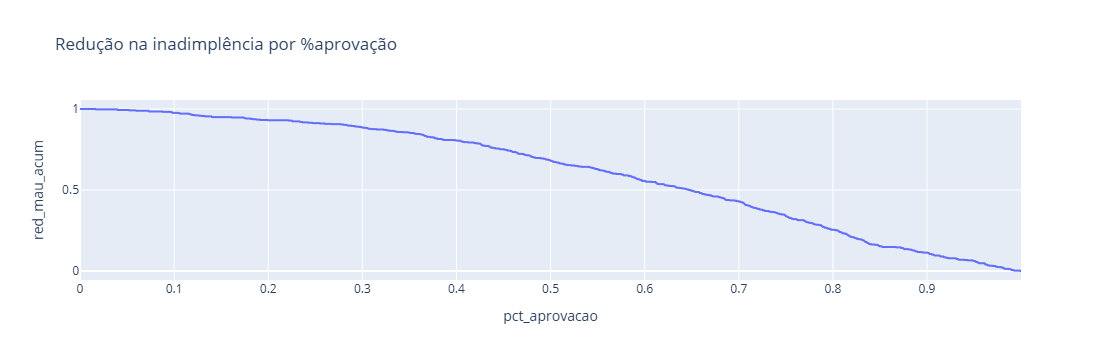

In [39]:
fig = px.line(df3, x="pct_aprovacao", y="red_mau_acum", title='Redução na inadimplência por %aprovação')
fig.show()

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [104]:
df.head()

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
404846 2015-09-01    F                N               S           0   
370876 2015-08-01    M                S               N           1   
239330 2015-05-01    F                S               N           0   
491326 2015-10-01    F                N               S           0   
271448 2015-06-01    F                N               S           0   

              tipo_renda           educacao estado_civil tipo_residencia  \
404846       Pensionista              Médio       Casado            Casa   
370876        Empresário  Superior completo       Casado   Governamental   
239330  Servidor público              Médio        União            Casa   
491326       Pensionista              Médio       Casado   Governamental   
271448       Assalariado              Médio       Casado            Casa   

        idade  tempo_emprego  qt_pessoas_residencia      renda  mau  ano_mes  \
404846     62       5.964384                    2.0    5466.64    0  2015-09   
370876     42       2.432877                    3.0   12398.49    0  2015-08   
239330     45      19.534247                    2.0  101062.66    0  2015-05   
491326     59       5.964384                    2.0   10774.15    0  2015-10   
271448     47       3.046575                    2.0    4083.24    0  2015-06   

                      renda_bin  bom     score  log_renda  
404846     (4100.062, 7927.126]    1  0.060147   8.606602  
370876    (7927.126, 13733.572]    1  0.081186   9.425411  
239330  (28010.372, 2734494.51]    1  0.016964  11.523506  
491326    (7927.126, 13733.572]    1  0.060147   9.284998  
271448      (200.239, 4100.062]    1  0.071202   8.314891

In [105]:
# Verifica se há nulos em qualquer coluna

df.isnull().sum()


data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
ano_mes                  0
renda_bin                0
bom                      0
score                    0
log_renda                0
dtype: int64

In [106]:
# substituir por mediana - tempo de emprego

df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)


In [107]:
# substituir por mediana - score

df['score'].fillna(df['score'].median(), inplace=True)

In [108]:
# Verifica se há nulos em qualquer coluna

df.isnull().sum()


data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
ano_mes                  0
renda_bin                0
bom                      0
score                    0
log_renda                0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [109]:
# selecionar apenas colunas numéricas

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'bom', 'score', 'log_renda'],
      dtype='object')

In [110]:
# outliers - 5% - 95%

k = 1.5 
outlier_report = {}

for col in num_cols:
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    IQR = Q3 - Q1

    limite_inf = Q1 - k * IQR
    limite_sup = Q3 + k * IQR

    outliers = df[(df[col] < limite_inf) | (df[col] > limite_sup)]
    qtd_outliers = outliers.shape[0]
    
    outlier_report[col] = qtd_outliers

    print(f"'{col}': {qtd_outliers} outliers (k={k})")


'qtd_filhos': 0 outliers (k=1.5)
'idade': 0 outliers (k=1.5)
'tempo_emprego': 0 outliers (k=1.5)
'qt_pessoas_residencia': 0 outliers (k=1.5)
'renda': 125 outliers (k=1.5)
'mau': 0 outliers (k=1.5)
'bom': 0 outliers (k=1.5)
'score': 0 outliers (k=1.5)
'log_renda': 0 outliers (k=1.5)


In [111]:
# tratando renda

df['log_renda'] = np.log1p(df['renda'])  # se não houver valores negativos


In [112]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7292 entries, 404846 to 503732
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               7292 non-null   datetime64[ns]
 1   sexo                   7292 non-null   object        
 2   posse_de_veiculo       7292 non-null   object        
 3   posse_de_imovel        7292 non-null   object        
 4   qtd_filhos             7292 non-null   int64         
 5   tipo_renda             7292 non-null   object        
 6   educacao               7292 non-null   object        
 7   estado_civil           7292 non-null   object        
 8   tipo_residencia        7292 non-null   object        
 9   idade                  7292 non-null   int64         
 10  tempo_emprego          7292 non-null   float64       
 11  qt_pessoas_residencia  7292 non-null   float64       
 12  renda                  7292 non-null   float64       
 13  m

In [113]:
# pegando todas as colunas - agora com log_renda

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'bom', 'score', 'log_renda'],
      dtype='object')

In [114]:
# outliers - 5% - 95%

k = 1.5 
outlier_report = {}

for col in num_cols:
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    IQR = Q3 - Q1

    limite_inf = Q1 - k * IQR
    limite_sup = Q3 + k * IQR

    outliers = df[(df[col] < limite_inf) | (df[col] > limite_sup)]
    qtd_outliers = outliers.shape[0]
    
    outlier_report[col] = qtd_outliers

    print(f"'{col}': {qtd_outliers} outliers (k={k})")

'qtd_filhos': 0 outliers (k=1.5)
'idade': 0 outliers (k=1.5)
'tempo_emprego': 0 outliers (k=1.5)
'qt_pessoas_residencia': 0 outliers (k=1.5)
'renda': 125 outliers (k=1.5)
'mau': 0 outliers (k=1.5)
'bom': 0 outliers (k=1.5)
'score': 0 outliers (k=1.5)
'log_renda': 0 outliers (k=1.5)


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [115]:
# Remova colunas que não fazem sentido ou são datetime

X = df.drop(columns=['mau', 'data_ref', 'ano_mes', 'renda_bin', 'bom'])

# Transformar categóricas em numéricas (one-hot)
X = pd.get_dummies(X, drop_first=True)

# Variável target
y = df['score']



In [116]:
# boruta

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', max_iter=100, random_state=42)
boruta_selector.fit(X.values, y.values)



BorutaPy(estimator=RandomForestRegressor(n_estimators=28, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1D1FB45BD40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1D1FB45BD40)

In [118]:
# variáveis importantes

selected_features = X.columns[boruta_selector.support_].to_list()
print("Variáveis importantes segundo Boruta:")
print(selected_features)


Variáveis importantes segundo Boruta:
['idade', 'score']


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [121]:
# Escalonar os dados

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [122]:
# aplicando PCA

pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)


In [123]:
# print

print("Variância explicada por cada componente:")
print(pca.explained_variance_ratio_)

print(f"Variância total explicada pelos 5 componentes: {sum(pca.explained_variance_ratio_):.2f}")


Variância explicada por cada componente:
[0.11751602 0.09865667 0.0750124  0.06972347 0.05309097]
Variância total explicada pelos 5 componentes: 0.41


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [124]:
# criação de dummies

categorical_cols = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

df_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [126]:
df_dummies.head()

data_ref  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  \
404846 2015-09-01           0     62       5.964384                    2.0   
370876 2015-08-01           1     42       2.432877                    3.0   
239330 2015-05-01           0     45      19.534247                    2.0   
491326 2015-10-01           0     59       5.964384                    2.0   
271448 2015-06-01           0     47       3.046575                    2.0   

            renda  mau  ano_mes                renda_bin  bom  ...  \
404846    5466.64    0  2015-09     (4100.062, 7927.126]    1  ...   
370876   12398.49    0  2015-08    (7927.126, 13733.572]    1  ...   
239330  101062.66    0  2015-05  (28010.372, 2734494.51]    1  ...   
491326   10774.15    0  2015-10    (7927.126, 13733.572]    1  ...   
271448    4083.24    0  2015-06      (200.239, 4100.062]    1  ...   

        educacao_Superior incompleto  estado_civil_Separado  \
404846                         False                  False   
370876                         False                  False   
239330                         False                  False   
491326                         False                  False   
271448                         False                  False   

        estado_civil_Solteiro  estado_civil_União  estado_civil_Viúvo  \
404846                  False               False               False   
370876                  False               False               False   
239330                  False                True               False   
491326                  False               False               False   
271448                  False               False               False   

        tipo_residencia_Casa  tipo_residencia_Com os pais  \
404846                  True                        False   
370876                 False                        False   
239330                  True                        False   
491326                 False                        False   
271448                  True                        False   

        tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
404846                        False                    False   
370876                        False                    False   
239330                        False                    False   
491326                        False                    False   
271448                        False                    False   

        tipo_residencia_Governamental  
404846                          False  
370876                           True  
239330                          False  
491326                           True  
271448                          False  

[5 rows x 32 columns]

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [128]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1. Substituição de nulos - usando mediana para numéricos
class SubstituirNulos(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_ = {}
    
    def fit(self, X, y=None):
        for col in X.select_dtypes(include=np.number).columns:
            self.median_[col] = X[col].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, med in self.median_.items():
            X[col].fillna(med, inplace=True)
        return X

# 2. Remoção de outliers pelo método IQR (substituindo por limites)
class RemoverOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k
        self.limits_ = {}
    
    def fit(self, X, y=None):
        for col in X.select_dtypes(include=np.number).columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inf = Q1 - self.k * IQR
            limite_sup = Q3 + self.k * IQR
            self.limits_[col] = (limite_inf, limite_sup)
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, (lim_inf, lim_sup) in self.limits_.items():
            X[col] = np.where(X[col] < lim_inf, lim_inf, X[col])
            X[col] = np.where(X[col] > lim_sup, lim_sup, X[col])
        return X

# Variável categórica para dummy
categorical_feature = ['posse_de_veiculo']

# Colunas numéricas (ajuste conforme seu dataset)
num_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'score']

# Pipeline para colunas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SubstituirNulos()),
    ('outlier', RemoverOutliers()),
    ('scaler', StandardScaler())
])

# Pipeline para coluna categórica com parâmetro corrigido
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combinando os preprocessamentos
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, categorical_feature)
])

# Pipeline completo com PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5, random_state=42))
])

# Exemplo de uso com o DataFrame 'df'
X = df[num_features + categorical_feature].copy()

X_transformed = pipeline.fit_transform(X)

print("Shape dos dados após pipeline + PCA:", X_transformed.shape)



Shape dos dados após pipeline + PCA: (7292, 5)


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [137]:
# carregando a base de dados

df = pd.read_feather('credit_scoring.ftr')

dataset = df.sample(10000)

In [138]:
# retirando colunas 

dataset.drop(['data_ref','index'], axis=1, inplace=True)


In [140]:


data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))


Conjunto de dados para modelagem (treino e teste): (9500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (500, 13)


In [141]:
from pycaret.classification import *

In [142]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

In [143]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [144]:
#forçando a variável qnt de filhos como numérica

data.qtd_filhos = data.qtd_filhos.astype(float)

In [145]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

In [146]:
# comparando modelos

best_model = compare_models(fold=10)

Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [148]:
# print

print(best_model)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [181]:
lightgbm = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [182]:
# lightgbm Hyperparameter Tunning

lightgbm_tuned = tune_model(lightgbm, optimize='F1')

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


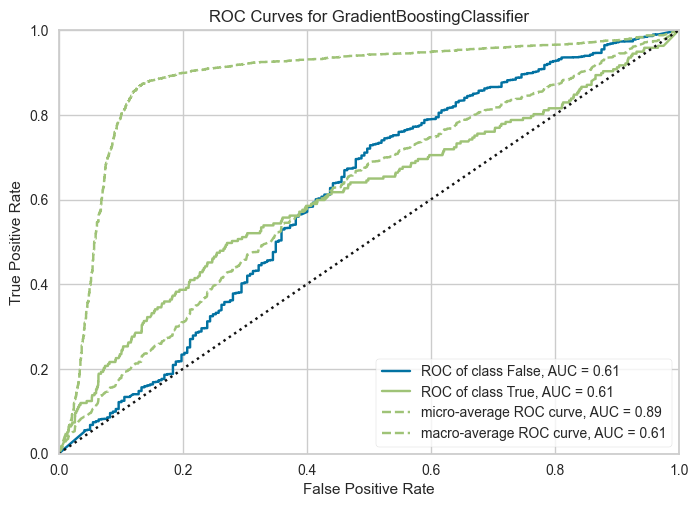

In [152]:
# AUC plot

plot_model(lightgbm_tuned, plot = 'auc')

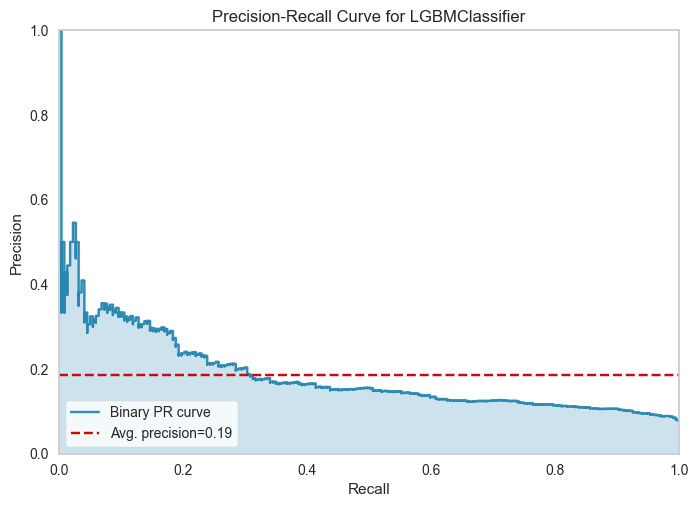

In [183]:
# Precision-Recall Plot

plot_model(lightgbm_tuned, plot = 'pr')

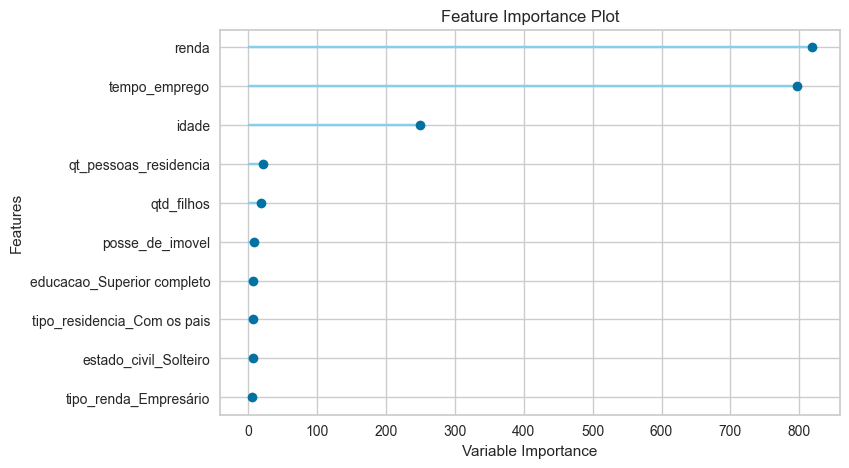

In [184]:
# Importância das variáveis (Feature Importance) Plot

plot_model(lightgbm_tuned, plot='feature')

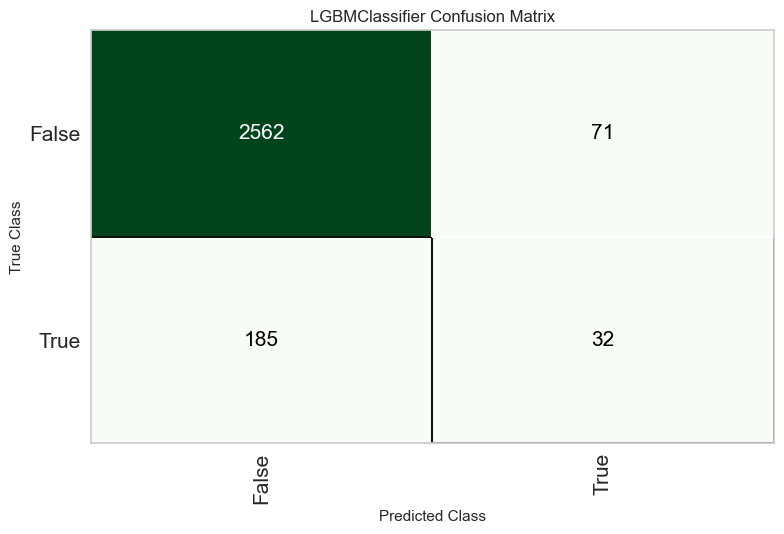

In [185]:
# Matriz de confusão (Confusion matrix)

plot_model(lightgbm_tuned, plot = 'confusion_matrix')

In [186]:
# Predict na amostra de validação / hold-out

predict_model(lightgbm_tuned);

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [187]:
# Finalizando o modelo para deploy

final_gbc = finalize_model(lightgbm_tuned)
print(final_gbc)


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [188]:
predict_model(lightgbm_tuned);

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [189]:
# Predizendo o conjunto de dados que não foi usado no treino

unseen_predictions = predict_model(final_gbc, data=data_unseen)
unseen_predictions.head()

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                S               S           0  Assalariado   
1    M                N               S           0  Assalariado   
2    F                S               S           0  Pensionista   
3    F                N               S           0  Pensionista   
4    F                S               S           0   Empresário   

            educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0  Superior completo        Viúvo            Casa     32       4.101370   
1              Médio       Casado            Casa     41       8.205480   
2  Superior completo       Casado            Casa     64            NaN   
3              Médio     Solteiro            Casa     63            NaN   
4  Superior completo       Casado            Casa     35       0.838356   

   qt_pessoas_residencia         renda    mau  prediction_label  \
0                    1.0   6809.540039  False                 0   
1                    2.0   2895.659912   True                 0   
2                    2.0   9334.639648  False                 0   
3                    1.0  12201.730469  False                 0   
4                    2.0   1786.280029  False                 1   

   prediction_score  
0            0.9883  
1            0.8270  
2            0.9664  
3            0.9929  
4            0.5594

In [190]:
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

In [191]:
# Garante que a coluna target e predição estejam alinhadas

y_true = unseen_predictions['mau']
y_pred = unseen_predictions['prediction_label']

acc = accuracy_score(y_true, y_pred)
print(f"Acurácia: {acc:.4f}")


Acurácia: 0.9000


In [192]:
# Salvando o modelo final

save_model(final_gbc,'Final GBC Model 02Jun2022')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

In [193]:
# Carregando o modelo salvo

saved_final_gbc = load_model('Final GBC Model 02Jun2022')


Transformation Pipeline and Model Successfully Loaded


In [194]:
# nova predição

new_prediction = predict_model(saved_final_gbc, data=data_unseen)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [195]:
# print

new_prediction.head()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                S               S           0  Assalariado   
1    M                N               S           0  Assalariado   
2    F                S               S           0  Pensionista   
3    F                N               S           0  Pensionista   
4    F                S               S           0   Empresário   

            educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0  Superior completo        Viúvo            Casa     32       4.101370   
1              Médio       Casado            Casa     41       8.205480   
2  Superior completo       Casado            Casa     64            NaN   
3              Médio     Solteiro            Casa     63            NaN   
4  Superior completo       Casado            Casa     35       0.838356   

   qt_pessoas_residencia         renda    mau  prediction_label  \
0                    1.0   6809.540039  False                 0   
1                    2.0   2895.659912   True                 0   
2                    2.0   9334.639648  False                 0   
3                    1.0  12201.730469  False                 0   
4                    2.0   1786.280029  False                 1   

   prediction_score  
0            0.9883  
1            0.8270  
2            0.9664  
3            0.9929  
4            0.5594

In [196]:
new_prediction.head()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                S               S           0  Assalariado   
1    M                N               S           0  Assalariado   
2    F                S               S           0  Pensionista   
3    F                N               S           0  Pensionista   
4    F                S               S           0   Empresário   

            educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0  Superior completo        Viúvo            Casa     32       4.101370   
1              Médio       Casado            Casa     41       8.205480   
2  Superior completo       Casado            Casa     64            NaN   
3              Médio     Solteiro            Casa     63            NaN   
4  Superior completo       Casado            Casa     35       0.838356   

   qt_pessoas_residencia         renda    mau  prediction_label  \
0                    1.0   6809.540039  False                 0   
1                    2.0   2895.659912   True                 0   
2                    2.0   9334.639648  False                 0   
3                    1.0  12201.730469  False                 0   
4                    2.0   1786.280029  False                 1   

   prediction_score  
0            0.9883  
1            0.8270  
2            0.9664  
3            0.9929  
4            0.5594

In [197]:
# Garante que a coluna target e predição estejam alinhadas

y_true = unseen_predictions['mau']
y_pred = unseen_predictions['prediction_label']

acc = accuracy_score(y_true, y_pred)
print(f"Acurácia: {acc:.4f}")


Acurácia: 0.9000


In [198]:
# nome dos passos

saved_final_gbc.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
